# **Conjunto de Dados de Funcionários**

Dados do Funcionário para Tarefa de Classificação Aprendizado Supervisionado

https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset/data

Contexto: Este conjunto de dados contém informações sobre funcionários de uma empresa, incluindo suas formações educacionais, histórico de trabalho, dados demográficos e fatores relacionados ao emprego. Ele foi tornado anônimo para proteger a privacidade e, ao mesmo tempo, fornecer insights valiosos sobre a força de trabalho.

**Colunas:**

* Education: Qualificações educacionais dos funcionários, incluindo diploma, instituição e área de estudo.
* Joining Year: ano em que cada funcionário ingressou na empresa, indicando seu tempo de serviço.
* City: O local ou cidade onde cada funcionário está baseado ou trabalha.
* Payment Tier: categorização de funcionários em diferentes níveis salariais.
* Age: a idade de cada funcionário, fornecendo informações demográficas.
* Gender: Identidade de gênero dos colaboradores, promovendo análise da diversidade.
* Ever Benched: indica se um funcionário já ficou temporariamente sem trabalho designado.
* Experience in Current Domain: número de anos de experiência que os funcionários têm em seu campo atual.
* Leave or Not: uma coluna de destino

**Uso**:
Este conjunto de dados pode ser usado para várias análises relacionadas a RH e força de trabalho, incluindo retenção de funcionários, avaliações de estrutura salarial, estudos de diversidade e inclusão e análises de padrões de licença. Pesquisadores, analistas de dados e profissionais de RH podem obter insights valiosos deste conjunto de dados.

**Possíveis perguntas de pesquisa:**

* Qual é a distribuição das qualificações educacionais entre os funcionários?
* Como o tempo de serviço (ano de ingresso) varia entre as diferentes cidades?
* Existe uma correlação entre Nível de Pagamento e Experiência no Domínio Atual?
* Qual é a distribuição de gênero na força de trabalho?
* Existe algum padrão no comportamento de afastamento entre os funcionários?

Esse dataset é bem clássico de churn/turnover (a variável LeaveOrNot já entrega isso 😉).

Entendimento rápido do problema

* **Tipo de problema**: Classificação binária

* **Target (y)**: LeaveOrNot (0 = fica, 1 = sai)

* **Features (X)**:
  * Categóricas: Education, City, Gender, EverBenched
  * Numéricas: JoiningYear, PaymentTier, Age, ExperienceInCurrentDomain

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, MaxAbsScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, classification_report, balanced_accuracy_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from sklearn.model_selection import FixedThresholdClassifier, TunedThresholdClassifierCV
from scipy.stats import chi2_contingency
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#!pip install xgboost
from xgboost import XGBClassifier

#!pip install lightgbm
from lightgbm import LGBMClassifier

#!pip install catboost
from catboost import CatBoostClassifier

#!pip install optuna
import optuna

In [178]:
!python --version

Python 3.11.0


In [179]:
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("tawfikelmetwally/employee-dataset")

#print("Path to dataset files:", path)

In [180]:
df = pd.read_csv('Employee.csv')
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [181]:
df.shape

(4653, 9)

In [182]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Education                  4653 non-null   str  
 1   JoiningYear                4653 non-null   int64
 2   City                       4653 non-null   str  
 3   PaymentTier                4653 non-null   int64
 4   Age                        4653 non-null   int64
 5   Gender                     4653 non-null   str  
 6   EverBenched                4653 non-null   str  
 7   ExperienceInCurrentDomain  4653 non-null   int64
 8   LeaveOrNot                 4653 non-null   int64
dtypes: int64(5), str(4)
memory usage: 327.3 KB


In [183]:
df.describe()

,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot
count,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000
mean,2015.062970,2.698259,29.393295,2.905652,0.343864
std,1.863377,0.561435,4.826087,1.558240,0.475047
min,2012.000000,1.000000,22.000000,0.000000,0.000000
25%,2013.000000,3.000000,26.000000,2.000000,0.000000
50%,2015.000000,3.000000,28.000000,3.000000,0.000000
75%,2017.000000,3.000000,32.000000,4.000000,1.000000
max,2018.000000,3.000000,41.000000,7.000000,1.000000


In [184]:
df.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

In [185]:
df.duplicated().sum()

np.int64(1889)

In [186]:
df[df.duplicated()].head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
111,Bachelors,2017,Pune,2,27,Female,No,5,1
130,Bachelors,2017,Bangalore,3,26,Female,No,4,0
138,Bachelors,2017,New Delhi,3,28,Male,No,2,0
160,Bachelors,2014,Bangalore,3,28,Female,No,3,0
167,Bachelors,2014,Bangalore,3,25,Male,No,3,0


In [187]:
print(df['Education'].unique())
print(df['City'].unique())
print(df['Gender'].unique())
print(df['EverBenched'].unique())

<StringArray>
['Bachelors', 'Masters', 'PHD']
Length: 3, dtype: str
<StringArray>
['Bangalore', 'Pune', 'New Delhi']
Length: 3, dtype: str
<StringArray>
['Male', 'Female']
Length: 2, dtype: str
<StringArray>
['No', 'Yes']
Length: 2, dtype: str


## **Outliers**

In [188]:
numericas = df.select_dtypes(include=['number', 'int64', 'float64']).columns
numericas

Index(['JoiningYear', 'PaymentTier', 'Age', 'ExperienceInCurrentDomain',
       'LeaveOrNot'],
      dtype='str')

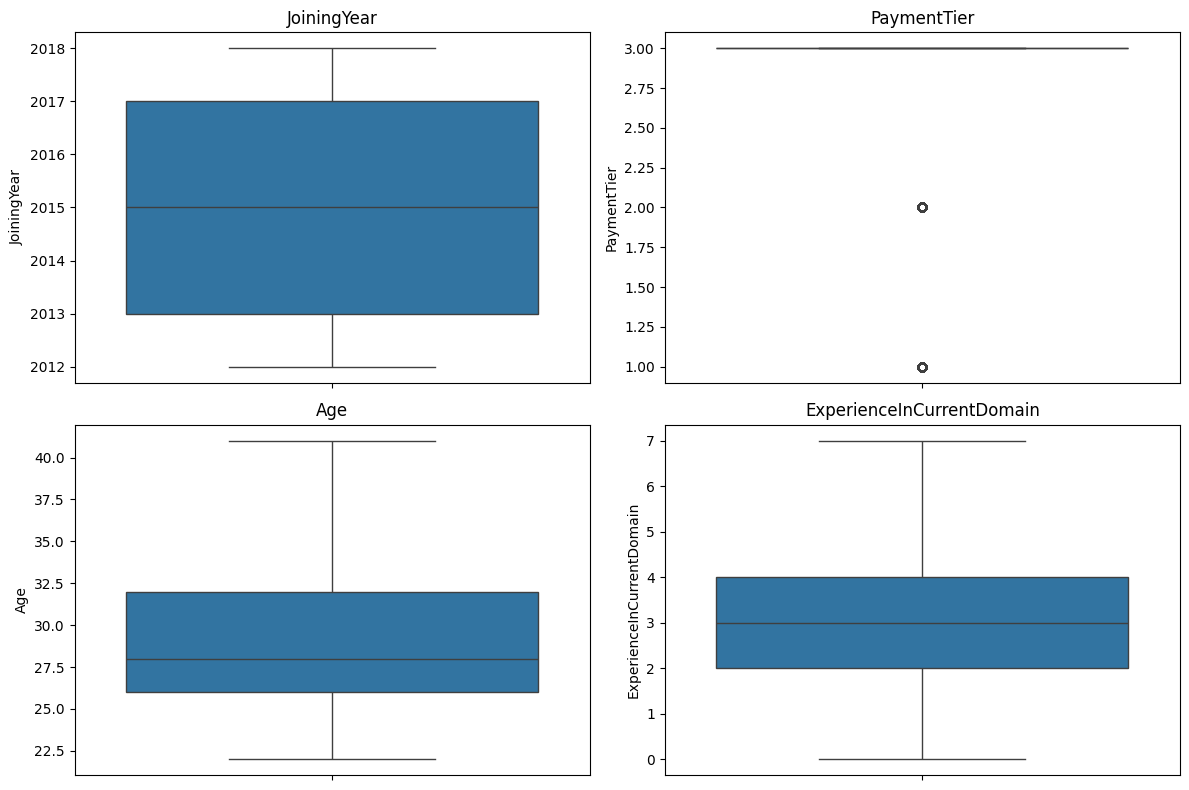

In [189]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes = axes.flatten()

for i, var in enumerate(['JoiningYear', 'PaymentTier', 'Age', 'ExperienceInCurrentDomain']):
    sns.boxplot(y=df[var], ax=axes[i])
    axes[i].set_title(var)

plt.tight_layout()
plt.show()

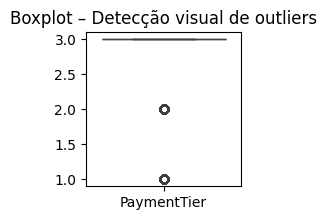

In [190]:
plt.figure(figsize=(2, 2))
sns.boxplot(data=df[['PaymentTier']])
plt.title("Boxplot – Detecção visual de outliers")
plt.show()

## **Correlação?**

Correlação serve para **medir o quanto duas variáveis estão relacionadas** entre si.

Ela responde perguntas como:

📈 Quando uma variável aumenta, a outra aumenta, diminui ou não muda?

🔗 Existe relação forte ou fraca entre elas?

🤖 Quais variáveis podem ser boas candidatas para modelos de Machine Learning?

**Valores da correlação**

O coeficiente varia de -1 a +1:

+1 → correlação positiva perfeita | -1 → correlação negativa perfeita | 0 → nenhuma relação linear

In [191]:
df_copy = df.copy()

df_copy['Education'] = df_copy['Education'].map({'Bachelors': 0, 'Masters': 1, 'PHD': 2})
df_copy['PaymentTier'] = df_copy['PaymentTier'].map({1: 0, 2: 1, 3: 2})

df_copy['Gender'] = df_copy['Gender'].map({'Male':1, 'Female':0})
df_copy['EverBenched'] = df_copy['EverBenched'].map({'Yes':1, 'No':0})

df_copy.head()


,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,0,2017,Bangalore,2,34,1,0,0,0
1,0,2013,Pune,0,28,0,0,3,1
2,0,2014,New Delhi,2,38,0,0,2,0
3,1,2016,Bangalore,2,27,1,0,5,1
4,1,2017,Pune,2,24,1,1,2,1


In [192]:
numericas = ['Age', 'JoiningYear', 'ExperienceInCurrentDomain']
categoricas_ordinal = ['Education', 'PaymentTier']
categoricas_nominal = ['City', 'Gender', 'EverBenched']

#### **Correlação de Pearson**: O coeficiente de correlação de Pearson mede a força e a direção da relação linear entre duas variáveis quantitativas (discretas ou contínuas).

✅ Quando usar (Numérica × Numérica | Númerica × Binária)

✔ Dados númericos
✔ Relação linear
✔ Distribuição aproximadamente normal
✔ Poucos outliers

**Exemplos:** Idade × Salário | Experiência × Performance | Feature numérica × target binário (0/1) se a numérica for normal

In [193]:
from scipy.stats import shapiro

# Hipótese Nula: Os dados seguem uma distribuição normal.
# Hipótese Alternativa: Os dados não seguem uma distribuição normal.

#🔑 Regra prática
# p ≤ 0.05 → ❌ Rejeita H₀
# p > 0.05 → ✅ Não rejeita H₀

for col in ['Age', 'JoiningYear', 'ExperienceInCurrentDomain']:
  stat, pvalue = shapiro(df_copy[col])
  print(f'{col}: p-valor = {pvalue:.4f}')

  alpha = 0.05  # Nível de significância
  if pvalue >= alpha:
    print("Aceita-se a hipótese nula: Os dados seguem uma distribuição normal.\n")
  else:
    print("Rejeita-se a hipótese nula: Os dados NÃO seguem uma distribuição normal.\n")



Age: p-valor = 0.0000
Rejeita-se a hipótese nula: Os dados NÃO seguem uma distribuição normal.

JoiningYear: p-valor = 0.0000
Rejeita-se a hipótese nula: Os dados NÃO seguem uma distribuição normal.

ExperienceInCurrentDomain: p-valor = 0.0000
Rejeita-se a hipótese nula: Os dados NÃO seguem uma distribuição normal.



    **Não podemos usar Pearson, pois as varíaveis númericas não seguem distribuição normal.**

In [194]:
from scipy.stats import shapiro
from scipy.stats import boxcox

df_copy['Age_log'] = np.log1p(df_copy['Age'])
df_copy['Age_boxcox'], lambda_age = boxcox(df_copy['Age'])

stat, pvalue = shapiro(df_copy['Age_boxcox'])

alpha = 0.05  # Nível de significância
if pvalue >= alpha:
  print("Aceita-se a hipótese nula: Os dados seguem uma distribuição normal.\n")
else:
  print("Rejeita-se a hipótese nula: Os dados NÃO seguem uma distribuição normal.\n")

Rejeita-se a hipótese nula: Os dados NÃO seguem uma distribuição normal.



#### **Correlação de Spearman**: O coeficiente de correlação de Spearman mede a força e a direção da relação monotônica (não necessariamente linear) entre duas variáveis ordinais.

✅ Quando usar (Ordinal × Ordinal | Ordinal × Numérica | Ordinal × Binária | Númerica NÃO Normal x Binária | Numérica NÃO normal × Numérica NÃO normal)

✔ Dados ordinais
✔ Relação monótona (não precisa ser linear)
✔ Dados não normais
✔ Presença de outliers

**Exemplos**: Escolaridade × Salário | Age (não normal) × LeaveOrNot

In [195]:
# Numérica NÃO normal × Numérica NÃO normal
df_copy[numericas].corr(method='spearman')


,Age,JoiningYear,ExperienceInCurrentDomain
Age,1.000000,0.007644,-0.141729
JoiningYear,0.007644,1.000000,-0.038441
ExperienceInCurrentDomain,-0.141729,-0.038441,1.000000


**Age vs ExperienceInCurrentDomain** = -0.1417  

→ Correlação negativa fraca: pessoas mais velhas não necessariamente têm mais experiência no domínio atual. Isso pode indicar mudanças de carreira ou entradas tardias em novas áreas.

**Age vs JoiningYear** = 0.0076  

→ Correlação praticamente nula: idade não está relacionada ao ano de entrada na empresa.

**JoiningYear vs ExperienceInCurrentDomain** = -0.0384  

→ Correlação negativa muito fraca: quem entrou mais recentemente não tem relação clara com o tempo de experiência no domínio.

🎯 **Insight**

As correlações são todas fracas ou próximas de zero, mostrando que essas variáveis são quase independentes.

Isso significa que cada uma pode trazer informação complementar ao modelo sem redundância.

O ponto mais interessante é a correlação negativa entre idade e experiência no domínio, sugerindo que idade não é um bom substituto para medir experiência — ambas devem ser usadas separadamente.

In [196]:
# Ordinal × Ordinal
df_copy[categoricas_ordinal].corr(method='spearman')

,Education,PaymentTier
Education,1.000000,-0.197092
PaymentTier,-0.197092,1.000000


**Education vs PaymentTier** = -0.197092 → correlação negativa fraca.

Esse valor negativo indica que, conforme o nível de Education aumenta, o PaymentTier tende a diminuir levemente (ou vice-versa).

🎯 **Insight**

Essa informação é útil porque mostra que Education e PaymentTier não são redundantes: cada variável traz informação diferente para o modelo.

O desalinhamento entre educação e salário pode ser um fator de insatisfação e, portanto, relevante para prever turnover.

In [197]:
# Ordinal × Binária | Númerica NÃO Normal x Binária
corr = df_copy[categoricas_ordinal + numericas].corrwith(df_copy['LeaveOrNot'], method='spearman', drop=True)
corr.name = 'LeaveOrNot'
corr


Education                    0.109075
PaymentTier                 -0.237405
Age                         -0.059512
JoiningYear                  0.185585
ExperienceInCurrentDomain   -0.031827
Name: LeaveOrNot, dtype: float64

**Education** = 0.109  

→ Correlação positiva fraca: níveis mais altos de educação estão levemente associados a maior chance de saída.

**PaymentTier** = -0.237  

→ Correlação negativa moderada: funcionários em faixas salariais mais altas tendem a permanecer, enquanto os de faixas mais baixas têm maior probabilidade de sair.

**Age** = -0.059  

→ Correlação negativa fraca: funcionários mais velhos têm uma pequena tendência a permanecer.

**JoiningYear** = 0.186  

→ Correlação positiva fraca: quem entrou mais recentemente tem maior chance de sair.

**ExperienceInCurrentDomain** = -0.032  

→ Correlação negativa muito fraca: mais experiência no domínio atual está levemente associada a permanecer.

🎯 **Insight**

A variável PaymentTier é a mais relevante aqui, pois mostra uma relação mais clara com o turnover.

JoiningYear também tem impacto: funcionários mais novos na empresa parecem mais propensos a sair.

As demais variáveis têm correlação fraca, mas podem contribuir em conjunto para o modelo.

In [198]:
# Ordinal × Numérica
df_copy[categoricas_ordinal + numericas].corr(method='spearman').loc[categoricas_ordinal, numericas]


,Age,JoiningYear,ExperienceInCurrentDomain
Education,-0.008782,0.174166,-0.012149
PaymentTier,0.011166,-0.135411,0.015191


**Education vs Age** = -0.009  

→ Correlação praticamente nula: nível de educação não está relacionado à idade.

**Education vs JoiningYear** = 0.174

→ Correlação positiva fraca: quem entrou mais recentemente tende a ter níveis de educação um pouco mais altos.

**Education vs ExperienceInCurrentDomain** = -0.012  

→ Correlação quase zero: educação não está ligada diretamente ao tempo de experiência no domínio atual.

**PaymentTier vs Age** = 0.011  

→ Correlação praticamente nula: faixa salarial não depende da idade.

**PaymentTier vs JoiningYear** = -0.135  

→ Correlação negativa fraca: funcionários que entraram mais recentemente tendem a estar em faixas salariais mais baixas.

**PaymentTier vs ExperienceInCurrentDomain** = 0.015  

→ Correlação quase zero: salário não está diretamente ligado ao tempo de experiência no domínio.

🎯 **Insight**

As correlações são todas fracas ou próximas de zero, mostrando que não há relações lineares fortes entre essas variáveis.

Os pontos mais relevantes são:

Educação mais alta em funcionários que entraram recentemente.

Funcionários novos tendem a estar em PaymentTier mais baixo.

Isso sugere que tempo de empresa e nível salarial podem ser fatores importantes para explicar o turnover, enquanto idade e experiência no domínio têm pouca relação direta com educação ou salário.

#### **Correlação de Kendall**

✅ Quando usar (Ordinal × Ordinal)

✔ Dados ordinais
✔ Amostras pequenas
✔ Muitos empates
✔ Análise estatística rigorosa


In [199]:
df_copy[categoricas_ordinal].corr(method='kendall')

,Education,PaymentTier
Education,1.000000,-0.190458
PaymentTier,-0.190458,1.000000


#### **Correlação de Point Biserial**

✅ Quando usar (Numérica Contínua × Binária (0/1) )

✔ Numérica contínua normal
✔ Variável binária real (0/1)
✔ Comparação de médias entre dois grupos

**Exemplos:** Idade × Churn | Salário × Compra (0/1)

#### **Qui-quadrado ou Cramér’s V** (Categórica × Categórica)

* Qui-quadrado de independência: Serve para verificar se há associação entre duas variáveis categóricas.
* Cramér’s V: Diz quão forte é a associação (Medida da força da associação).

**Exemplos:** Gender × City | Gender × LeaveOrNot | City × LeaveOrNot | EverBenched × LeaveOrNot

In [200]:
def cramers_v(confusion_matrix):
  chi2 = chi2_contingency(confusion_matrix)[0]
  n = confusion_matrix.sum().sum()
  r, k = confusion_matrix.shape

  f = np.sqrt(chi2 / (n * (min(r, k) - 1)))

  result = ''
  if f < 0.10:
    result = 'Desprezível'
  elif (f >= 0.10) and (f < 0.30):
    result = 'Fraca'
  elif (f >= 0.30) and (f < 0.50):
    result = 'Moderada'
  else:
    result = 'Forte'

  return f, result

In [201]:
# Hipótese Nula: Não há evidência de associação
# Hipótese Alternativa: Existe associação estatisticamente significativa

tabela = pd.crosstab(df_copy['Gender'], df_copy['LeaveOrNot'])
chi2, pvalue, dof, expected = chi2_contingency(tabela)
print(f'chi2: {chi2}, pvalue: {pvalue}, dof: {dof}, expected: {expected}')

alpha = 0.05  # Nível de significância
if pvalue >= alpha:
  print("Aceita-se a hipótese nula: Não há evidência de associação estatisticamente significativa.\n")
else:
  print("Rejeita-se a hipótese nula: Existe associação estatisticamente significativa.\n")

f, result = cramers_v(tabela)
print(f'\nForça da Associação: {f} {result}')

# Odds Ratio (Quem tem maior chance de sair?)
a = tabela.iloc[0,0]
b = tabela.iloc[0,1]
c = tabela.iloc[1,0]
d = tabela.iloc[1,1]

odds_ratio = (b/a) / (d/c)
print(f'\nOdds Ratio: {odds_ratio:.4f}')

if odds_ratio > 1:
  print('Gênero 0 Feminino tem maior chance de sair')
elif odds_ratio < 1:
  print('Gênero 1 Masculino tem maior chance de sair')
else:
  print('Chances semelhantes')

chi2: 225.6953561969211, pvalue: 5.177873883438753e-51, dof: 1, expected: [[1230.2546744  644.7453256]
 [1822.7453256  955.2546744]]
Rejeita-se a hipótese nula: Existe associação estatisticamente significativa.


Força da Associação: 0.22023928344475469 Fraca

Odds Ratio: 2.5689
Gênero 0 Feminino tem maior chance de sair


H0:👉 Não há evidência de associação
H1:👉 Existe associação estatisticamente significativa

1️⃣ p-value extremamente pequeno

📌 p ≈ 0.000000000000000000000000000000000000000000000005

👉 Rejeitamos totalmente a hipótese nula (H₀)
👉 As duas variáveis NÃO são independentes

Conclusão clara:

Existe uma associação estatisticamente MUITO forte entre as variáveis analisadas.

2️⃣ Valor de χ² muito alto

📌 Um χ² = 225 em uma tabela 2×2 é gigante

👉 Esse é o valor da estatística qui-quadrado. Quanto maior, maior a evidência de que existe associação entre as variáveis analisadas.

3️⃣ Graus de liberdade = 1

📌 Confirma que você está analisando:

Binária × Binária
(ex: Gender × LeaveOrNot ou EverBenched × LeaveOrNot)

Nada de errado aqui 👍

4️⃣ Expected (frequências esperadas)
[[1230.25   644.75]]

→ Esses são os valores esperados se não houvesse associação entre as variáveis.

→ O teste compara os valores observados com esses esperados. A grande diferença entre eles é o que gera o chi2 alto.

👉 O teste é estatisticamente válido

❗ O ponto MAIS IMPORTANTE: ⚠️ Significativo ≠ forte

Com base apenas no Qui-quadrado, você pode afirmar:

✔️ Existe associação
❌ NÃO pode afirmar quão forte é
❌ NÃO pode afirmar causalidade

🎯 Interpretação prática

O resultado mostra que Gender e LeaveOrNot não são independentes.

Existe uma associação estatisticamente significativa: o gênero está relacionado à probabilidade de saída.

Como o p-value é tão pequeno, podemos afirmar com confiança que essa relação não é fruto do acaso.

In [202]:
df_copy['Gender'].value_counts()

Gender
1    2778
0    1875
Name: count, dtype: int64

In [203]:
import statsmodels.api as sm

X_ = sm.add_constant(df_copy['Gender'])
y_ = df_copy['LeaveOrNot']

modelo = sm.Logit(y_, X_).fit(method='newton')
print(modelo.summary())


Optimization terminated successfully.
         Current function value: 0.619373
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             LeaveOrNot   No. Observations:                 4653
Model:                          Logit   Df Residuals:                     4651
Method:                           MLE   Df Model:                            1
Date:                Tue, 17 Feb 2026   Pseudo R-squ.:                 0.03759
Time:                        10:33:26   Log-Likelihood:                -2881.9
converged:                       True   LL-Null:                       -2994.5
Covariance Type:            nonrobust   LLR p-value:                 6.865e-51
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1143      0.046     -2.470      0.014      -0.205      -0.024
Gender        -0.9435      0.

Gender = -0.9435 | p-value = 0.000

✔ É significativo? Sim. p < 0.001

Na regressão logística:

* Coeficiente negativo → diminui a chance de saída

* Coeficiente positivo → aumenta a chance de saída

O coeficiente de Gender é negativo (-0.9435). Logo diminui a chance de saída do grupo comparado a base

Então: O gênero codificado como 1 (Masculino) tem MENOR chance de sair da empresa comparado ao gênero 0 (Feminino).

Na regressão logística, o coeficiente está em log-odds. 

Conversão para Odds Ratio -> OR = np.exp(-0.9435) = 0.39 -> (1 - 0.39 = 0.61 * 100 → 61%)

OR = 0.39 significa que: O gênero 1 (Masculino) tem aproximadamente 61% MENOS CHANCE DE SAIR da empresa comparado ao gênero 0 (Feminino).

Em regressão logística, a categoria 0 é sempre o grupo base.

* Gender = 0 → grupo de referência
* Gender = 1 → grupo comparado ao referência


In [204]:
odds_ratio = round(np.exp(-0.9435), 2)
odds_ratio 

np.float64(0.39)

🎯 O que significa a constante (-0.1143)?

A constante representa: O log-odds de saída quando Gender = 0

Ou seja: 👉 É o valor base do grupo de referência.

🔎 Convertendo para algo interpretável

Primeiro transformamos log-odds em probabilidade.

Passo 1 — calcular odds: 𝑜𝑑𝑑𝑠= 𝑒−0.1143 ≈ 0.892

Passo 2 — transformar em probabilidade:
𝑝 = 0.892 / 1 + 0.892 ≈ 0.47

📊 Interpretação prática

👉 Quando Gender = 0, a probabilidade estimada de saída é 47%.

🎯 E para Gender = 1?

Agora somamos o coeficiente:

𝑧 = −0.1143 − 0.9435 = −1.0578

Transformando: 𝑝 ≈ 0.26

👉 Quando Gender = 1, a probabilidade estimada é 26%.

A constante é o risco base (grupo 0).

O coeficiente ajusta esse risco quando muda para 1.

Se: 0 = Female e 1 = Male
Então: 👉 Mulheres têm probabilidade maior de saída (47% vs 26%).

📉 Pseudo R² = 0.037

Significa: Gender sozinho explica cerca de 3,7% da variação na saída.

Ou seja: ✔ Existe associação ❌ Não é o único fator importante

In [205]:
# Coeficientes
beta_0 = modelo.params['const']
beta_1 = modelo.params['Gender']

# Intervalo de confiança (log-odds)
conf = modelo.conf_int()
ci_lower = conf.loc['Gender', 0]
ci_upper = conf.loc['Gender', 1]

# -----------------------------
# Grupo base (Gender = 0)
# -----------------------------
odds_0 = np.exp(beta_0)
p_0 = odds_0 / (1 + odds_0)

# -----------------------------
# Grupo comparado (Gender = 1)
# -----------------------------
z_1 = beta_0 + beta_1
odds_1 = np.exp(z_1)
p_1 = odds_1 / (1 + odds_1)

# -----------------------------
# Odds Ratio
# -----------------------------
odds_ratio = np.exp(beta_1)

# Redução percentual
reducao = (1 - odds_ratio) * 100

# Intervalo de confiança do OR
or_ci_lower = np.exp(ci_lower)
or_ci_upper = np.exp(ci_upper)

print("===== RESULTADOS =====\n")

print(f"β0 (constante): {beta_0:.6f}")
print(f"β1 (Gender): {beta_1:.6f}\n")

print(f"Probabilidade Gender=0: {p_0:.4f} ({p_0*100:.2f}%)")
print(f"Probabilidade Gender=1: {p_1:.4f} ({p_1*100:.2f}%)\n")

print(f"Odds Ratio: {odds_ratio:.4f}")
print(f"Variação percentual (via Odds Ratio): {reducao:.2f}%")
print(f"IC 95% OR: ({or_ci_lower:.4f}, {or_ci_upper:.4f})")


===== RESULTADOS =====

β0 (constante): -0.114257
β1 (Gender): -0.943494

Probabilidade Gender=0: 0.4715 (47.15%)
Probabilidade Gender=1: 0.2577 (25.77%)

Odds Ratio: 0.3893
Variação percentual (via Odds Ratio): 61.07%
IC 95% OR: (0.3438, 0.4408)


In [206]:
tabela = pd.crosstab(df_copy['City'], df_copy['LeaveOrNot'])
chi2, pvalue, dof, expected = chi2_contingency(tabela)
print(f'chi2: {chi2}, pvalue: {pvalue}, dof: {dof}, expected: {expected}')

alpha = 0.05  # Nível de significância
if pvalue >= alpha:
  print("Aceita-se a hipótese nula: Não há evidência de associação estatisticamente significativa.\n")
else:
  print("Rejeita-se a hipótese nula: Existe associação estatisticamente significativa.\n")

f, result = cramers_v(tabela)
print(f'\nForça da Associação: {f} {result}')

chi2: 206.15885400194648, pvalue: 1.7106992135618012e-45, dof: 2, expected: [[1461.8706211   766.1293789 ]
 [ 759.14915109  397.85084891]
 [ 831.98022781  436.01977219]]
Rejeita-se a hipótese nula: Existe associação estatisticamente significativa.


Força da Associação: 0.210491454654786 Fraca


In [207]:
df_copy['City'].value_counts()

City
Bangalore    2228
Pune         1268
New Delhi    1157
Name: count, dtype: int64

In [208]:
one = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first').set_output(transform='pandas')

df_dummies = one.fit_transform(df_copy[['City']])
df_dummies.head()

,City_New Delhi,City_Pune
0,0.0,0.0
1,0.0,1.0
2,1.0,0.0
3,0.0,0.0
4,0.0,1.0


👉 Bangalore vira referência (base)

👉 O modelo vai comparar:

Pune vs Bangalore

New Delhi vs Bangalore

In [209]:
X_ = sm.add_constant(df_dummies)
y_ = df_copy['LeaveOrNot']

modelo = sm.Logit(y_, X_).fit(method='newton')
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.621933
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             LeaveOrNot   No. Observations:                 4653
Model:                          Logit   Df Residuals:                     4650
Method:                           MLE   Df Model:                            2
Date:                Tue, 17 Feb 2026   Pseudo R-squ.:                 0.03361
Time:                        10:33:27   Log-Likelihood:                -2893.9
converged:                       True   LL-Null:                       -2994.5
Covariance Type:            nonrobust   LLR p-value:                 1.932e-44
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.0096      0.048    -21.084      0.000      -1.103      -0.916
City_New Delhi   

✔ Existe associação estatisticamente significativa entre City e saída da empresa.

p-value = 1.932e-44. Extremamente menor que 0.05.

📍 City_New Delhi

Coef = 0.2389 | p = 0.003 (significativo)

Odds Ratio = np.exp(0.2389) = 1.27 -> (1 - 1.27 = 0.27 → 27%)

Isso significa: As chances (odds) são 1.27 vezes maiores que a base.

Então dizemos: Funcionários de New Delhi têm 27% mais chance de sair comparado a Bangalore.

⚠️ Mas isso NÃO significa que a probabilidade aumentou 27%.

📍 City_Pune

Coef = 1.0254 | p < 0.001 (muito significativo)

Odds Ratio = np.exp(1.0254) = 2.79 -> (2.79 - 1 = 1.79 * 100 → 179%)

Isso significa: As chances (odds) são 2.79 vezes maiores que a base.

Então dizemos: Funcionários de Pune têm 179% mais chance de sair comparado a Bangalore.

⚠️ Mas isso NÃO significa que a probabilidade aumentou 179%.

🔎 Constante (-1.0096)

Representa o log-odds de saída para a cidade base (Bangalore).

Transformando em probabilidade:

𝑝 = 𝑒−1.0096 / 1 + 𝑒 −1.0096 ≈ 0.27

Ou seja: 👉 Em Bangalore, a probabilidade média de saída é ~27%.

📊 Pseudo R² = 0.033

Baixo (3,3%), mas:

✔ Existe efeito significativo ❌ City sozinha não explica totalmente a saída

🎯 Conclusão Estatística

Existe associação estatisticamente significativa entre cidade e desligamento (p < 0.001). Em comparação com Bangalore:

Funcionários de New Delhi apresentam 27% maior chance de saída.

Funcionários de Pune apresentam 179% maior chance de saída.

In [210]:
odds_ratio = round(np.exp(0.2389), 2)
odds_ratio 

np.float64(1.27)

In [211]:
odds_ratio = round(np.exp(1.0254), 2)
odds_ratio 

np.float64(2.79)

In [212]:
# Coeficientes
params = modelo.params
conf = modelo.conf_int()

beta_0 = params['const']

# -----------------------------
# Probabilidade da cidade base
# -----------------------------
odds_base = np.exp(beta_0)
p_base = odds_base / (1 + odds_base)

print("===== CIDADE BASE =====")
print(f"Probabilidade base: {p_base:.4f} ({p_base*100:.2f}%)\n")

# -----------------------------
# Para cada cidade dummy
# -----------------------------
for var in params.index:
    if var != 'const':
        
        beta = params[var]
        
        # log-odds
        z = beta_0 + beta
        
        # odds e probabilidade
        odds = np.exp(z)
        p = odds / (1 + odds)
        
        # Odds Ratio
        or_value = np.exp(beta)
        
        # Redução ou aumento percentual
        variacao = (or_value - 1) * 100
        
        # IC do OR
        ci_lower = np.exp(conf.loc[var, 0])
        ci_upper = np.exp(conf.loc[var, 1])
        
        print(f"===== {var} =====")
        print(f"Probabilidade: {p:.4f} ({p*100:.2f}%)")
        print(f"Odds Ratio: {or_value:.4f}")
        print(f"Variação percentual (via Odds Ratio): {variacao:.2f}%")
        print(f"IC 95% OR: ({ci_lower:.4f}, {ci_upper:.4f})\n")


===== CIDADE BASE =====
Probabilidade base: 0.2671 (26.71%)

===== City_New Delhi =====
Probabilidade: 0.3163 (31.63%)
Odds Ratio: 1.2699
Variação percentual (via Odds Ratio): 26.99%
IC 95% OR: (1.0871, 1.4835)

===== City_Pune =====
Probabilidade: 0.5039 (50.39%)
Odds Ratio: 2.7882
Variação percentual (via Odds Ratio): 178.82%
IC 95% OR: (2.4126, 3.2222)



In [213]:
tabela = pd.crosstab(df_copy['EverBenched'], df_copy['LeaveOrNot'])
chi2, pvalue, dof, expected = chi2_contingency(tabela)
print(f'chi2: {chi2}, pvalue: {pvalue}, dof: {dof}, expected: {expected}')

alpha = 0.05  # Nível de significância
if pvalue >= alpha:
  print("Aceita-se a hipótese nula: Não há evidência de associação estatisticamente significativa.\n")
else:
  print("Rejeita-se a hipótese nula: Existe associação estatisticamente significativa.\n")

f, result = cramers_v(tabela)
print(f'\nForça da Associação: {f} {result}')

chi2: 28.086147926708364, pvalue: 1.1603340647939294e-07, dof: 1, expected: [[2739.36707501 1435.63292499]
 [ 313.63292499  164.36707501]]
Rejeita-se a hipótese nula: Existe associação estatisticamente significativa.


Força da Associação: 0.07769258349365131 Desprezível


In [214]:
X_ = sm.add_constant(df_copy['EverBenched'])
y_ = df_copy['LeaveOrNot']

modelo = sm.Logit(y_, X_).fit(method='newton')
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.640596
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             LeaveOrNot   No. Observations:                 4653
Model:                          Logit   Df Residuals:                     4651
Method:                           MLE   Df Model:                            1
Date:                Tue, 17 Feb 2026   Pseudo R-squ.:                0.004613
Time:                        10:33:27   Log-Likelihood:                -2980.7
converged:                       True   LL-Null:                       -2994.5
Covariance Type:            nonrobust   LLR p-value:                 1.470e-07
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.7025      0.033    -21.364      0.000      -0.767      -0.638
EverBenched     0.5179    

✔ Existe associação estatisticamente significativa entre EverBenched e saída da empresa.

p-value é menor que 0.05.

* EverBenched = 0 → nunca foi benchado
* EverBenched = 1 → já foi benchado

🔵 1️⃣ Constante (-0.7025)

A constante representa o log-odds de sair da empresa para quem NUNCA foi benchado (EverBenched = 0).

👉 Probabilidade de saída para quem nunca foi benchado: 33.1%

🔵 2️⃣ Coeficiente EverBenched (0.5179)

Odds Ratio = np.exp(0.5179) = 1.678 -> (1 - 1.678 = 0.678 → 67.8%)

👉 Quem já foi benchado tem 67.8% mais chances de sair da empresa comparado a quem nunca foi benchado.

⚠️ Isso é aumento nas odds, não diretamente na probabilidade.

👉 Probabilidade de saída para quem foi benchado: 45.4%

In [215]:
# 1️⃣ Extrair coeficientes
beta_0 = modelo.params['const']
beta_bench = modelo.params['EverBenched']

# 2️⃣ Log-odds para EverBenched = 1
z_0 = beta_0
z_1 = beta_0 + beta_bench

# 3️⃣ Converter para probabilidade
p_1 = 1 / (1 + np.exp(-z_1))
p_0 = 1 / (1 + np.exp(-z_0))

# 4️⃣ Odds Ratio
or_bench = np.exp(beta_bench)

# 5️⃣ Variação percentual via OR
variacao = (or_bench - 1) * 100

# 6️⃣ Intervalo de confiança do OR
conf = modelo.conf_int()
ci_lower = np.exp(conf.loc['EverBenched', 0])
ci_upper = np.exp(conf.loc['EverBenched', 1])

print("===== RESULTADO PARA EVERBENCHED (1 vs 0) =====\n")

print(f"EverBenched = 0 → {p_0:.4f} ({p_0*100:.2f}%)")
print(f"EverBenched = 1 → {p_1:.4f} ({p_1*100:.2f}%)")
print(f"Odds Ratio: {or_bench:.4f}")
print(f"Variação percentual (via Odds Ratio): {variacao:.2f}%")
print(f"IC 95% OR: ({ci_lower:.4f}, {ci_upper:.4f})")


===== RESULTADO PARA EVERBENCHED (1 vs 0) =====

EverBenched = 0 → 0.3313 (33.13%)
EverBenched = 1 → 0.4540 (45.40%)
Odds Ratio: 1.6785
Variação percentual (via Odds Ratio): 67.85%
IC 95% OR: (1.3863, 2.0322)


## **Análises**

#### LeaveOrNot

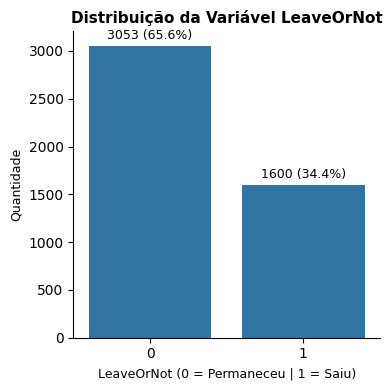

In [216]:
plt.figure(figsize=(4, 4))

ax = sns.countplot(x='LeaveOrNot', data=df)

ax.bar_label(
    ax.containers[0],
    labels=[
        f'{int(v)} ({v/len(df):.1%})'
        for v in ax.containers[0].datavalues
    ],
    padding=3,
    fontsize=9
)

ax.set_title('Distribuição da Variável LeaveOrNot', fontsize=11, weight='bold')
ax.set_xlabel('LeaveOrNot (0 = Permaneceu | 1 = Saiu)', fontsize=9)
ax.set_ylabel('Quantidade', fontsize=9)

sns.despine()
plt.tight_layout()
plt.show()


Dados desbalanceados

#### Gender x LeaveOrNot

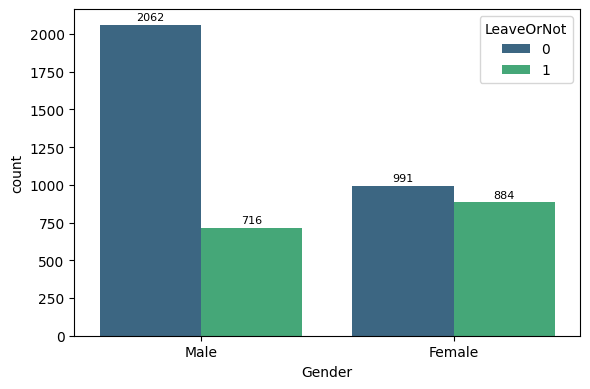

In [217]:
plt.figure(figsize=(6, 4))

ax = sns.countplot(x="Gender", hue="LeaveOrNot", data=df, palette="viridis")

# Rótulos automáticos em TODAS as barras
for container in ax.containers:
    ax.bar_label(
        container,
        label_type='edge',
        padding=2,
        fontsize=8
    )

plt.tight_layout()
plt.show()


Gênero Feminino tem maior chance de sair

#### City x LeaveOrNot

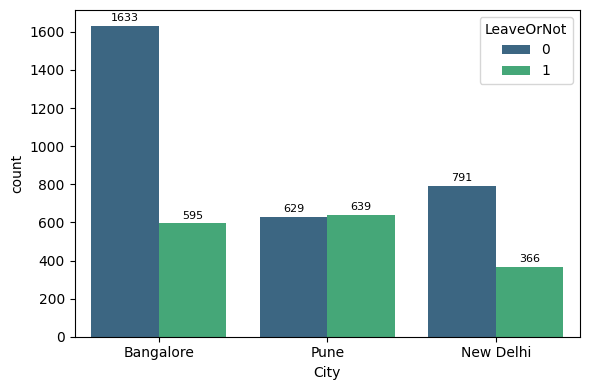

In [218]:
plt.figure(figsize=(6, 4))

ax = sns.countplot(x="City", hue="LeaveOrNot", data=df, palette="viridis")

# Rótulos automáticos em TODAS as barras
for container in ax.containers:
    ax.bar_label(
        container, label_type='edge', padding=2, fontsize=8)

plt.tight_layout()
plt.show()

Pune tem mais saidas do que permanencia

#### PaymentTier x LeaveOrNot

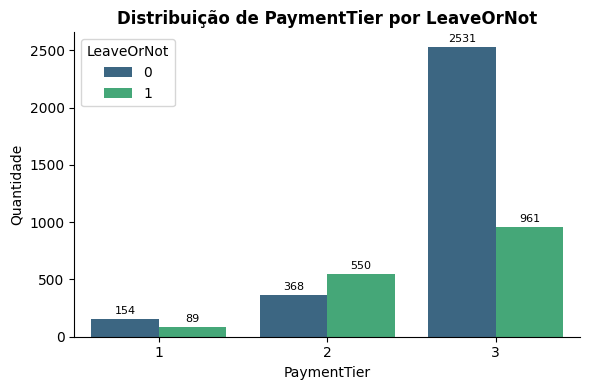

In [219]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x="PaymentTier", hue="LeaveOrNot", data=df, palette="viridis")
ax.set_title("Distribuição de PaymentTier por LeaveOrNot", weight="bold")
ax.set_xlabel("PaymentTier")
ax.set_ylabel("Quantidade")

for container in ax.containers:
    ax.bar_label(container, fontsize=8, padding=2)

sns.despine()
plt.tight_layout()
plt.show()


No PaymentTier 2 tem mais saidas do que permanencias

#### Education x LeaveOrNot

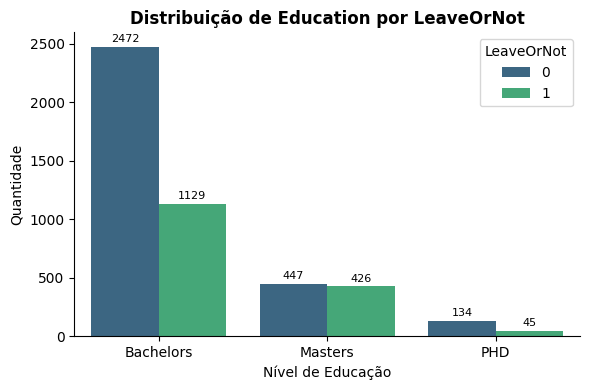

In [220]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x="Education", hue="LeaveOrNot", data=df, palette="viridis")
ax.set_title("Distribuição de Education por LeaveOrNot", weight="bold")
ax.set_xlabel("Nível de Educação")
ax.set_ylabel("Quantidade")

for container in ax.containers:
    ax.bar_label(container, fontsize=8, padding=2)

sns.despine()
plt.tight_layout()
plt.show()


📊 O que o gráfico revela

**Bachelors** → É o grupo mais numeroso e também o que concentra a maior quantidade de desligamentos.

**Masters** → Aqui há quase um equilíbrio: praticamente metade ficou e metade saiu.

**PhD** → Grupo pequeno, com maior proporção de permanência.

**🔎 Interpretação**

O nível Bachelors domina a base, mas também apresenta um número expressivo de saídas.

O nível Masters chama atenção porque tem uma taxa de saída muito alta (quase 50%), sugerindo que esse grupo pode estar mais insatisfeito ou mais propenso a buscar novas oportunidades.

O nível PhD é pequeno, mas mostra maior retenção relativa.

#### Education X PaymentTier

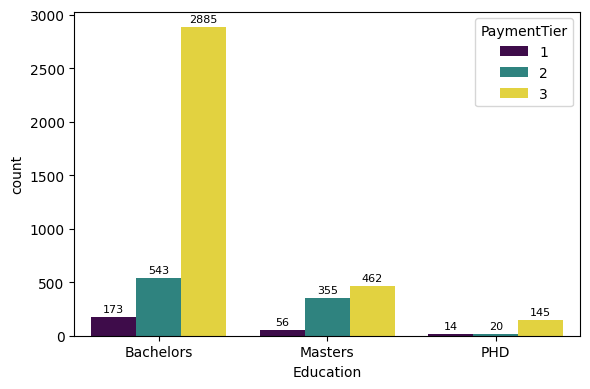

In [221]:
plt.figure(figsize=(6, 4))

ax = sns.countplot(x="Education", hue="PaymentTier", data=df, palette="viridis")

# Rótulos automáticos em TODAS as barras
for container in ax.containers:
    ax.bar_label(
        container,
        label_type='edge',
        padding=2,
        fontsize=8
    )

plt.tight_layout()
plt.show()


**🔎 O que os números dizem**

**Bachelors:** Faixa 1: 173 | Faixa 2: 543 | Faixa 3: 2885

→ A maioria esmagadora está na faixa salarial 3, mesmo com apenas graduação.

**Masters:** Faixa 1: 56 | Faixa 2: 355 | Faixa 3: 462

→ Aqui vemos uma distribuição mais equilibrada, mas ainda com predominância na faixa 3.

**PhD:** Faixa 1: 14 | Faixa 2: 20 | Faixa 3: 145

→ Apesar de serem menos pessoas, a concentração também está na faixa 3.

**📌 Interpretação**

Existe uma tendência clara: quanto maior a escolaridade, maior a proporção de pessoas nas faixas salariais mais altas.

Mas o dado curioso é que até quem tem apenas Bachelors já aparece em grande número na faixa 3, sugerindo que outros fatores (como experiência ou cidade) também influenciam bastante.

O PhD tem menos casos absolutos, mas quase todos estão na faixa mais alta, reforçando a ideia de que doutorado está associado a salários maiores.

In [222]:
# Education (Bachelors, Masters, PhD) e PaymentTier (1,2,3)

# 1. Contagem absoluta
contagem = df.groupby(["Education", "PaymentTier"]).size().reset_index(name="Count")

# 2. Calcular proporção dentro de cada nível de escolaridade
contagem["Proportion"] = contagem.groupby("Education")["Count"].transform(lambda x: x / x.sum())

# 3. Visualizar tabela
contagem

,Education,PaymentTier,Count,Proportion
0,Bachelors,1,173,0.048042
1,Bachelors,2,543,0.150791
2,Bachelors,3,2885,0.801166
3,Masters,1,56,0.064147
4,Masters,2,355,0.406644
5,Masters,3,462,0.529210
6,PHD,1,14,0.078212
7,PHD,2,20,0.111732
8,PHD,3,145,0.810056


#### Education × PaymentTier × LeaveOrNot

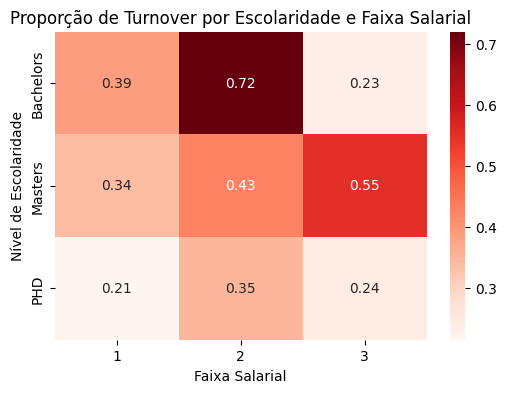

In [223]:
# Proporção de quem saiu por Education e PaymentTier
prop = pd.crosstab([df['Education'], df['PaymentTier']], df['LeaveOrNot'], normalize='index')

# Heatmap da coluna 1 (quem saiu)
plt.figure(figsize=(6,4))
sns.heatmap(prop[1].unstack(), annot=True, fmt=".2f", cmap="Reds")
plt.title("Proporção de Turnover por Escolaridade e Faixa Salarial")
plt.xlabel("Faixa Salarial")
plt.ylabel("Nível de Escolaridade")
plt.show()

🎯 **Insight**

Com essa tabela, você consegue ver quais combinações de escolaridade × faixa salarial têm maior risco de saída. 

Por exemplo, se Bachelors + PaymentTier 2 tem taxa de saída de 72%, esse grupo é crítico para políticas de retenção.

Funcionários em faixas salariais mais baixas têm maior probabilidade de sair. PaymentTier

Funcionários com níveis mais altos de educação estão levemente associados a maior chance de saída. Education


#### PaymentTier × JoiningYear x LeaveOrNot

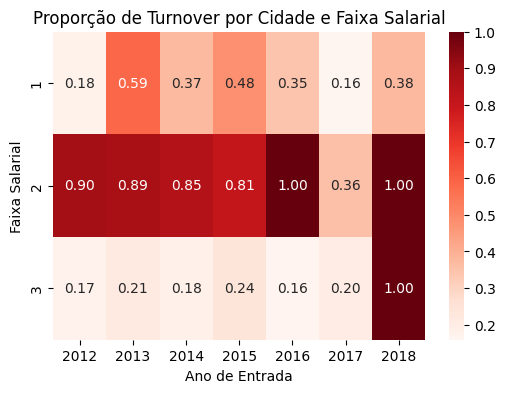

In [224]:
# Proporção de quem saiu por Education e PaymentTier
prop = pd.crosstab([df['PaymentTier'], df['JoiningYear']], df['LeaveOrNot'], normalize='index')

# Heatmap da coluna 1 (quem saiu)
plt.figure(figsize=(6,4))
sns.heatmap(prop[1].unstack(), annot=True, fmt=".2f", cmap="Reds")
plt.title("Proporção de Turnover por Cidade e Faixa Salarial")
plt.xlabel("Ano de Entrada")
plt.ylabel("Faixa Salarial")
plt.show()

#### Education × JoiningYear x LeaveOrNot

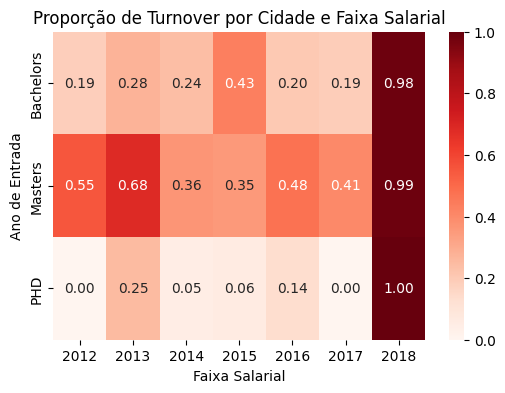

In [225]:
# Proporção de quem saiu por Education e PaymentTier
prop = pd.crosstab([df['Education'], df['JoiningYear']], df['LeaveOrNot'], normalize='index')

# Heatmap da coluna 1 (quem saiu)
plt.figure(figsize=(6,4))
sns.heatmap(prop[1].unstack(), annot=True, fmt=".2f", cmap="Reds")
plt.title("Proporção de Turnover por Cidade e Faixa Salarial")
plt.xlabel("Faixa Salarial")
plt.ylabel("Ano de Entrada")
plt.show()

#### City × PaymentTier × LeaveOrNot

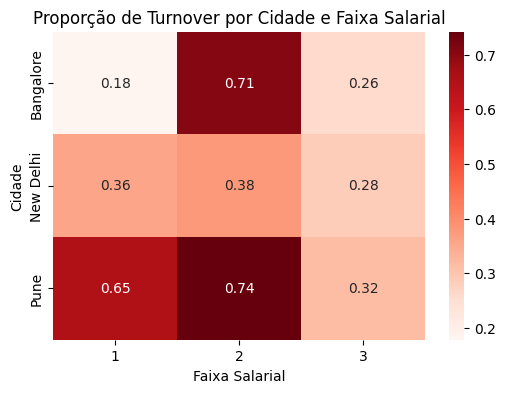

In [226]:
# Proporção de quem saiu por Education e PaymentTier
prop = pd.crosstab([df['City'], df['PaymentTier']], df['LeaveOrNot'], normalize='index')

# Heatmap da coluna 1 (quem saiu)
plt.figure(figsize=(6,4))
sns.heatmap(prop[1].unstack(), annot=True, fmt=".2f", cmap="Reds")
plt.title("Proporção de Turnover por Cidade e Faixa Salarial")
plt.xlabel("Faixa Salarial")
plt.ylabel("Cidade")
plt.show()

#### City × Education × LeaveOrNot

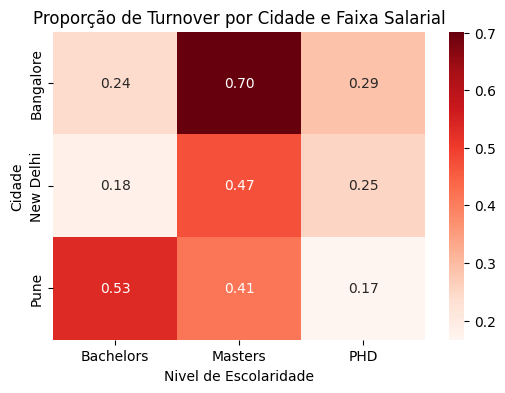

In [227]:
# Proporção de quem saiu por Education e PaymentTier
prop = pd.crosstab([df['City'], df['Education']], df['LeaveOrNot'], normalize='index')

# Heatmap da coluna 1 (quem saiu)
plt.figure(figsize=(6,4))
sns.heatmap(prop[1].unstack(), annot=True, fmt=".2f", cmap="Reds")
plt.title("Proporção de Turnover por Cidade e Faixa Salarial")
plt.xlabel("Nivel de Escolaridade")
plt.ylabel("Cidade")
plt.show()

#### City × JoiningYear × LeaveOrNot

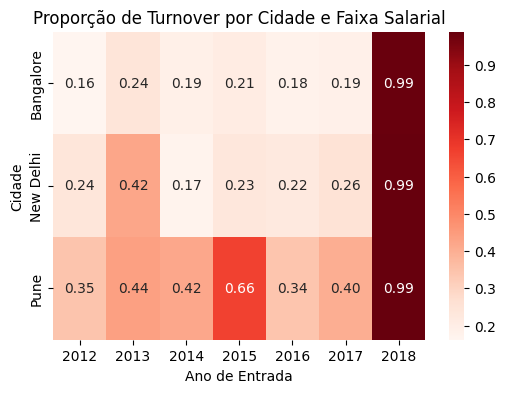

In [228]:
# Proporção de quem saiu por Education e PaymentTier
prop = pd.crosstab([df['City'], df['JoiningYear']], df['LeaveOrNot'], normalize='index')

# Heatmap da coluna 1 (quem saiu)
plt.figure(figsize=(6,4))
sns.heatmap(prop[1].unstack(), annot=True, fmt=".2f", cmap="Reds")
plt.title("Proporção de Turnover por Cidade e Faixa Salarial")
plt.xlabel("Ano de Entrada")
plt.ylabel("Cidade")
plt.show()

In [229]:
df.groupby(['City', 'JoiningYear'])['LeaveOrNot'].mean().round(2).reset_index()

,City,JoiningYear,LeaveOrNot
0,Bangalore,2012,0.16
1,Bangalore,2013,0.24
2,Bangalore,2014,0.19
3,Bangalore,2015,0.21
4,Bangalore,2016,0.18
5,Bangalore,2017,0.19
6,Bangalore,2018,0.99
7,New Delhi,2012,0.24
8,New Delhi,2013,0.42
9,New Delhi,2014,0.17


#### Gender x JoiningYear x LeaveOrNot

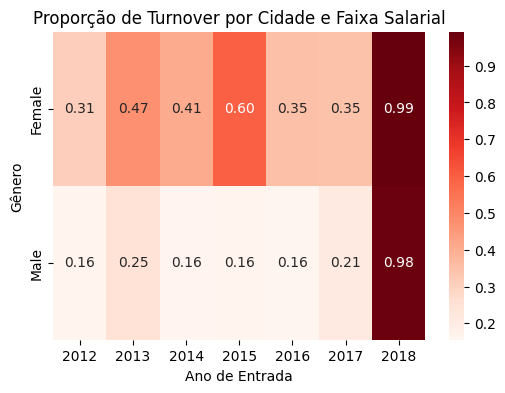

In [230]:
# Proporção de quem saiu por Education e PaymentTier
prop = pd.crosstab([df['Gender'], df['JoiningYear']], df['LeaveOrNot'], normalize='index')

# Heatmap da coluna 1 (quem saiu)
plt.figure(figsize=(6,4))
sns.heatmap(prop[1].unstack(), annot=True, fmt=".2f", cmap="Reds")
plt.title("Proporção de Turnover por Cidade e Faixa Salarial")
plt.xlabel("Ano de Entrada")
plt.ylabel("Gênero")
plt.show()

In [231]:
df.groupby(['Gender', 'JoiningYear'])['LeaveOrNot'].mean().round(2).reset_index()

,Gender,JoiningYear,LeaveOrNot
0,Female,2012,0.31
1,Female,2013,0.47
2,Female,2014,0.41
3,Female,2015,0.60
4,Female,2016,0.35
5,Female,2017,0.35
6,Female,2018,0.99
7,Male,2012,0.16
8,Male,2013,0.25
9,Male,2014,0.16


#### Gender x PaymentTier x LeaveOrNot

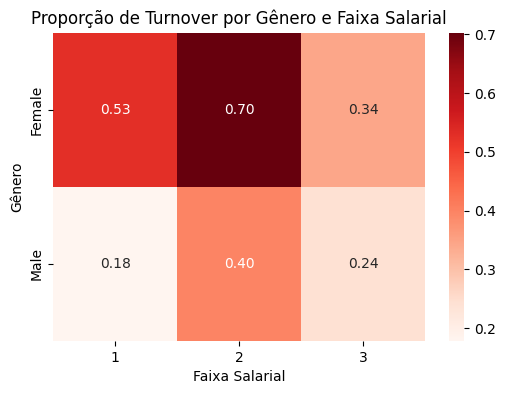

In [232]:
# Proporção de quem saiu por Education e PaymentTier
prop = pd.crosstab([df['Gender'], df['PaymentTier']], df['LeaveOrNot'], normalize='index')

# Heatmap da coluna 1 (quem saiu)
plt.figure(figsize=(6,4))
sns.heatmap(prop[1].unstack(), annot=True, fmt=".2f", cmap="Reds")
plt.title("Proporção de Turnover por Gênero e Faixa Salarial")
plt.xlabel("Faixa Salarial")
plt.ylabel("Gênero")
plt.show()

Mulheres na faixa salarial 2 têm turnover mais alto (0.70).

In [233]:
# Calcula proporção de turnover por grupo no treino
df.groupby(['Gender', 'PaymentTier'])['LeaveOrNot'].mean().round(2).reset_index()


,Gender,PaymentTier,LeaveOrNot
0,Female,1,0.53
1,Female,2,0.70
2,Female,3,0.34
3,Male,1,0.18
4,Male,2,0.40
5,Male,3,0.24


## **Limpeza**

In [234]:
#df = df.drop_duplicates()
df = df.reset_index(drop=True)

## **Split treino / teste**




In [235]:
X = df.drop(['LeaveOrNot'], axis=1)
y = df[['LeaveOrNot']]

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [237]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [238]:
X_train.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
0,Bachelors,2012,New Delhi,3,38,Female,No,1
1,Bachelors,2018,Bangalore,3,26,Male,No,4
2,Bachelors,2016,Pune,3,27,Male,No,5
3,Bachelors,2016,Bangalore,3,36,Male,No,4
4,Bachelors,2017,Bangalore,3,27,Male,Yes,5


In [239]:
y_train.value_counts()

LeaveOrNot
0             2442
1             1280
Name: count, dtype: int64

In [240]:
y_test.value_counts()

LeaveOrNot
0             611
1             320
Name: count, dtype: int64

In [241]:
# 🔒 Regra: y SEMPRE deve ser 1D
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
y_train

array([0, 1, 0, ..., 1, 0, 0], shape=(3722,))

## **Feature Engineering**

✅ Regra de ouro

**As novas features devem ser criadas antes ou depois do split de dados?**

👉 DEPENDE do tipo de variável.

Mas já adianto:

🔒 Quase todas as variáveis temporais devem ser criadas ANTES do split, desde que NÃO usem informação do futuro nem da variável alvo.

🟢 Pode ser feito ANTES do split (seguro)

São transformações determinísticas, que não usam estatísticas globais:

* Extração de: ano, mês, dia, idade a partir de data

* Features temporais: time_diff, log_time, log_time_diff, time_bin, is_first_hour,
is_peak_fraud_window, time_diff_diff. ✔ Usam apenas: Time, ordem cronológica, operações locais (diff, log, cut)

* Criação de regras de negócio fixas

* Flags (is_weekend, has_children)

* Interações simples (renda / idade)

📌 Essas não “olham” os dados para aprender nada.

📌 Não usam Target nem estatísticas globais do alvo

🔴 Deve ser feito DEPOIS do split (obrigatório)

Features que usam o alvo (Class) → DEPOIS do split

Qualquer coisa que aprende parâmetros com os dados: Escalonamento, Encoding, Imputação, Outliers, Seleção de Variáveis, Balanceamento de Dados.

**Técnicas de Feature Engineering:**

* Criação de Novas Variáveis (Feature Creation)

* Transformações de Variáveis Numéricas

* Encoding de Variáveis Categóricas

* Tratamento de Outliers

* Feature Selection (seleção de variáveis)

* Normalização e Padronização

* Redução de Dimensionalidade

### **Transformações de Variáveis Numéricas**

Usadas para reduzir assimetria, outliers e melhorar a performance.

Principais técnicas:

Logarítmica, Raiz Quadrada, Box-Cox / Yeo-Johnson, Binning (discretização)

In [242]:
df['Age'].min(), df['Age'].max()

(np.int64(22), np.int64(41))

In [243]:
bins = [21, 28, 35, 42]
labels = ["Young", "Mid", "Senior"]

In [244]:
X_train["AgeGroup"] = pd.cut(X_train["Age"], bins=bins, labels=labels)
X_test["AgeGroup"] = pd.cut(X_test["Age"], bins=bins, labels=labels)

### **Criação de Novas Variáveis (Feature Creation)**

In [245]:
df_train = pd.concat([X_train.reset_index(drop=True), pd.Series(y_train, name="LeaveOrNot").reset_index(drop=True)], axis=1)
df_train.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,AgeGroup,LeaveOrNot
0,Bachelors,2012,New Delhi,3,38,Female,No,1,Senior,0
1,Bachelors,2018,Bangalore,3,26,Male,No,4,Young,1
2,Bachelors,2016,Pune,3,27,Male,No,5,Young,0
3,Bachelors,2016,Bangalore,3,36,Male,No,4,Senior,0
4,Bachelors,2017,Bangalore,3,27,Male,Yes,5,Young,0


In [246]:
# Taxa de Saída por Gênero x Faixa Salarial
# Mulheres na faixa salarial 2 têm turnover mais alto (0.70).
turnover_gen_salary = df_train.groupby(['Gender', 'PaymentTier'])['LeaveOrNot'].mean().round(2).reset_index(name="TurnoverRiskByGenSalary")
X_train = X_train.merge(turnover_gen_salary, on=['Gender', 'PaymentTier'], how="left")
X_test  = X_test.merge(turnover_gen_salary, on=['Gender', 'PaymentTier'], how="left")

turnover_gen_join = df_train.groupby(['Gender', 'JoiningYear'])['LeaveOrNot'].mean().round(2).reset_index(name="TurnoverRiskByGenJoin")
X_train = X_train.merge(turnover_gen_join, on=['Gender', 'JoiningYear'], how="left")
X_test  = X_test.merge(turnover_gen_join, on=['Gender', 'JoiningYear'], how="left")

turnover_city_join = df_train.groupby(['City', 'JoiningYear'])['LeaveOrNot'].mean().round(2).reset_index(name="TurnoverRiskByCityJoin")
X_train = X_train.merge(turnover_city_join, on=['City', 'JoiningYear'], how="left")
X_test  = X_test.merge(turnover_city_join, on=['City', 'JoiningYear'], how="left")

turnover_city_edu = df_train.groupby(['City', 'Education'])['LeaveOrNot'].mean().round(2).reset_index(name="TurnoverRiskByCityEdu")
X_train = X_train.merge(turnover_city_edu, on=['City', 'Education'], how="left")
X_test  = X_test.merge(turnover_city_edu, on=['City', 'Education'], how="left")

turnover_city_salary = df_train.groupby(['City', 'PaymentTier'])['LeaveOrNot'].mean().round(2).reset_index(name="TurnoverRiskByCitySalary")
X_train = X_train.merge(turnover_city_salary, on=['City', 'PaymentTier'], how="left")
X_test  = X_test.merge(turnover_city_salary, on=['City', 'PaymentTier'], how="left")

turnover_edu_join = df_train.groupby(['Education', 'JoiningYear'])['LeaveOrNot'].mean().round(2).reset_index(name="TurnoverRiskByEduJoin")
X_train = X_train.merge(turnover_edu_join, on=['Education', 'JoiningYear'], how="left")
X_test  = X_test.merge(turnover_edu_join, on=['Education', 'JoiningYear'], how="left")

turnover_salary_join = df_train.groupby(['PaymentTier', 'JoiningYear'])['LeaveOrNot'].mean().round(2).reset_index(name="TurnoverRiskBySalaryJoin")
X_train = X_train.merge(turnover_salary_join, on=['PaymentTier', 'JoiningYear'], how="left")
X_test  = X_test.merge(turnover_salary_join, on=['PaymentTier', 'JoiningYear'], how="left")

turnover_edu_salary = df_train.groupby(["Education", "PaymentTier"])["LeaveOrNot"].mean().round(2).reset_index(name="TurnoverRiskByEduSalary")
X_train = X_train.merge(turnover_edu_salary, on=["Education", "PaymentTier"], how="left")
X_test  = X_test.merge(turnover_edu_salary, on=["Education", "PaymentTier"], how="left")

# Proporção de Saída (LeaveOrNot = 1) por Gênero
# O gênero Feminino tem mais chance de sair
turnover_gender = df_train.groupby("Gender")["LeaveOrNot"].mean().round(2).reset_index(name="TurnoverRiskByGender")
X_train = X_train.merge(turnover_gender, on=['Gender'], how="left")
X_test  = X_test.merge(turnover_gender, on=['Gender'], how="left")

# Proporção de Saída (LeaveOrNot = 1) por Cidade
# Pessoas em Pune tem mais chance de sair
turnover_city = df_train.groupby("City")["LeaveOrNot"].mean().round(2).reset_index(name="TurnoverRiskByCity")
X_train = X_train.merge(turnover_city, on=['City'], how="left")
X_test  = X_test.merge(turnover_city, on=['City'], how="left")

turnover_ever = df_train.groupby("EverBenched")["LeaveOrNot"].mean().round(2).reset_index(name="TurnoverRiskByEverBenched")
X_train = X_train.merge(turnover_ever, on=['EverBenched'], how="left")
X_test  = X_test.merge(turnover_ever, on=['EverBenched'], how="left")

In [247]:
turnover_city

,City,TurnoverRiskByCity
0,Bangalore,0.27
1,New Delhi,0.32
2,Pune,0.49


In [248]:
df_train.groupby("EverBenched")["LeaveOrNot"].mean().round(2).reset_index(name="TurnoverRiskByCity")

,EverBenched,TurnoverRiskByCity
0,No,0.33
1,Yes,0.46


### **Encoding de Variáveis Categóricas**

Transformar texto em números sem perder significado.

**Tipos:**

* Label Encoding (⚠️ apenas para y)
* One-Hot Encoding
* Target Encoding
* Frequency Encoding
* Ordinal Encoding (quando existe ordem)


**fit_transform SOMENTE no treino**

🚨 Por que NÃO pode fazer One-Hot antes do split?

🔥 Problemas sérios:

**1. Data Leakage** O encoder “aprendeu” categorias que só existem no teste

**2. Avaliação irreal** O modelo viu informação do futuro

**3. Resultado inflado** Métricas parecem melhores do que realmente são

**4. Erro em produção** O pipeline não se replica no mundo real

Em produção, você nunca terá acesso aos dados futuros.

🧠 Regra de ouro

Tudo que aprende parâmetros deve ser ajustado apenas no treino

Isso inclui:

* One-Hot Encoder
* StandardScaler
* MinMaxScaler
* SMOTE
* PCA
* Feature Selection

In [249]:
X_train.info()

<class 'pandas.DataFrame'>
RangeIndex: 3722 entries, 0 to 3721
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Education                  3722 non-null   str     
 1   JoiningYear                3722 non-null   int64   
 2   City                       3722 non-null   str     
 3   PaymentTier                3722 non-null   int64   
 4   Age                        3722 non-null   int64   
 5   Gender                     3722 non-null   str     
 6   EverBenched                3722 non-null   str     
 7   ExperienceInCurrentDomain  3722 non-null   int64   
 8   AgeGroup                   3722 non-null   category
 9   TurnoverRiskByGenSalary    3722 non-null   float64 
 10  TurnoverRiskByGenJoin      3722 non-null   float64 
 11  TurnoverRiskByCityJoin     3722 non-null   float64 
 12  TurnoverRiskByCityEdu      3722 non-null   float64 
 13  TurnoverRiskByCitySalary   3722 non-null   f

In [250]:
categoricas = X_train.select_dtypes(include=['object', 'category', 'str']).columns
numericas = X_train.select_dtypes(include=['number', 'int64', 'float64']).columns

In [251]:
for col in categoricas:
  print(col, ".....:", len(X_train[col].unique()))
  print(X_train[col].unique(), '\n')

Education .....: 3
<StringArray>
['Bachelors', 'Masters', 'PHD']
Length: 3, dtype: str 

City .....: 3
<StringArray>
['New Delhi', 'Bangalore', 'Pune']
Length: 3, dtype: str 

Gender .....: 2
<StringArray>
['Female', 'Male']
Length: 2, dtype: str 

EverBenched .....: 2
<StringArray>
['No', 'Yes']
Length: 2, dtype: str 

AgeGroup .....: 3
['Senior', 'Young', 'Mid']
Categories (3, str): ['Young' < 'Mid' < 'Senior'] 



In [252]:
for col in numericas:
  print(col, ".....:", len(X_train[col].unique()))
  print(X_train[col].unique(), '\n')

JoiningYear .....: 7
[2012 2018 2016 2017 2013 2015 2014] 

PaymentTier .....: 3
[3 2 1] 

Age .....: 20
[38 26 27 36 28 30 40 39 25 32 41 29 23 24 34 22 31 35 37 33] 

ExperienceInCurrentDomain .....: 8
[1 4 5 2 0 3 6 7] 

TurnoverRiskByGenSalary .....: 6
[0.34 0.25 0.4  0.7  0.18 0.54] 

TurnoverRiskByGenJoin .....: 13
[0.32 0.99 0.15 0.22 0.24 0.17 1.   0.59 0.34 0.35 0.4  0.48 0.16] 

TurnoverRiskByCityJoin .....: 16
[0.26 0.98 0.33 0.17 0.2  0.25 0.18 1.   0.65 0.4  0.24 0.32 0.42 0.23
 0.22 0.15] 

TurnoverRiskByCityEdu .....: 9
[0.18 0.25 0.52 0.69 0.29 0.4  0.47 0.15 0.3 ] 

TurnoverRiskByCitySalary .....: 9
[0.29 0.26 0.31 0.7  0.74 0.38 0.37 0.19 0.67] 

TurnoverRiskByEduJoin .....: 17
[0.19 0.99 0.2  0.28 0.4  0.   0.43 0.47 1.   0.23 0.56 0.37 0.11 0.07
 0.63 0.35 0.29] 

TurnoverRiskBySalaryJoin .....: 16
[0.18 1.   0.17 0.21 0.2  0.35 0.81 0.16 0.9  0.42 0.24 0.88 0.59 0.32
 0.4  0.46] 

TurnoverRiskByEduSalary .....: 8
[0.23 0.42 0.27 0.72 0.55 0.36 0.4  0.17] 

Turnover

**Education (Ordinal)**

Tem ordem natural, então NÃO é One-Hot.

Ordem lógica: Bachelors < Masters < PHD


**PaymentTier**

Apesar de ser número, é categórico ordinal discreto (1, 2, 3).

👉 Duas opções válidas:

Manter como está (minha escolha inicial)

Ou tratar como ordinal

In [253]:
# Variáveis ordinais
categoricas_ordinal = ['Education', 'PaymentTier', 'AgeGroup']

In [254]:
# ===== Ordinal =====

# Ordem explícita
education_order = ['Bachelors', 'Masters', 'PHD']
payment_order = [1, 2, 3]
age_order = ["Young", "Mid", "Senior"]

ordinal = OrdinalEncoder(categories=[education_order, payment_order, age_order])
ordinal.fit_transform(X_train[categoricas_ordinal])

array([[0., 2., 2.],
       [0., 2., 0.],
       [0., 2., 0.],
       ...,
       [1., 2., 0.],
       [0., 2., 0.],
       [0., 2., 0.]], shape=(3722, 3))

In [255]:
X_train[categoricas_ordinal] = ordinal.fit_transform(X_train[categoricas_ordinal])
X_test[categoricas_ordinal] = ordinal.transform(X_test[categoricas_ordinal])
X_train.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,AgeGroup,TurnoverRiskByGenSalary,TurnoverRiskByGenJoin,TurnoverRiskByCityJoin,TurnoverRiskByCityEdu,TurnoverRiskByCitySalary,TurnoverRiskByEduJoin,TurnoverRiskBySalaryJoin,TurnoverRiskByEduSalary,TurnoverRiskByGender,TurnoverRiskByCity,TurnoverRiskByEverBenched
0,0.0,2012,New Delhi,2.0,38,Female,No,1,2.0,0.34,0.32,0.26,0.18,0.29,0.19,0.18,0.23,0.47,0.32,0.33
1,0.0,2018,Bangalore,2.0,26,Male,No,4,0.0,0.25,0.99,0.98,0.25,0.26,0.99,1.00,0.23,0.26,0.27,0.33
2,0.0,2016,Pune,2.0,27,Male,No,5,0.0,0.25,0.15,0.33,0.52,0.31,0.20,0.17,0.23,0.26,0.49,0.33
3,0.0,2016,Bangalore,2.0,36,Male,No,4,2.0,0.25,0.15,0.17,0.25,0.26,0.20,0.17,0.23,0.26,0.27,0.33
4,0.0,2017,Bangalore,2.0,27,Male,Yes,5,0.0,0.25,0.22,0.20,0.25,0.26,0.19,0.21,0.23,0.26,0.27,0.46


**City, Gender, EverBenched (Nominais)**

Não existe hierarquia

Poucas categorias

✔️ OneHotEncoder

In [256]:
categoricas_nominal = ['City', 'Gender', 'EverBenched']

In [257]:
# ===== Nominal (One-Hot) =====
onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first').set_output(transform='pandas')

onehot.fit_transform(X_train[categoricas_nominal])

,City_New Delhi,City_Pune,Gender_Male,EverBenched_Yes
0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,1.0
...,...,...,...,...
3717,1.0,0.0,1.0,0.0
3718,0.0,0.0,1.0,1.0
3719,0.0,1.0,1.0,0.0
3720,0.0,0.0,1.0,0.0


In [258]:
onehot.get_feature_names_out(categoricas_nominal)

array(['City_New Delhi', 'City_Pune', 'Gender_Male', 'EverBenched_Yes'],
      dtype=object)

In [259]:
X_train_encoded = onehot.fit_transform(X_train[categoricas_nominal])
X_train = pd.concat([X_train, X_train_encoded], axis=1)

X_test_encoded = onehot.fit_transform(X_test[categoricas_nominal])
X_test = pd.concat([X_test, X_test_encoded], axis=1)

X_train.head()

#X_train[onehot.get_feature_names_out(categoricas_nominal)] = onehot.fit_transform(X_train[categoricas_nominal])
#X_test[onehot.get_feature_names_out(categoricas_nominal)] = onehot.transform(X_test[categoricas_nominal])

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,AgeGroup,TurnoverRiskByGenSalary,...,TurnoverRiskByEduJoin,TurnoverRiskBySalaryJoin,TurnoverRiskByEduSalary,TurnoverRiskByGender,TurnoverRiskByCity,TurnoverRiskByEverBenched,City_New Delhi,City_Pune,Gender_Male,EverBenched_Yes
0,0.0,2012,New Delhi,2.0,38,Female,No,1,2.0,0.34,...,0.19,0.18,0.23,0.47,0.32,0.33,1.0,0.0,0.0,0.0
1,0.0,2018,Bangalore,2.0,26,Male,No,4,0.0,0.25,...,0.99,1.00,0.23,0.26,0.27,0.33,0.0,0.0,1.0,0.0
2,0.0,2016,Pune,2.0,27,Male,No,5,0.0,0.25,...,0.20,0.17,0.23,0.26,0.49,0.33,0.0,1.0,1.0,0.0
3,0.0,2016,Bangalore,2.0,36,Male,No,4,2.0,0.25,...,0.20,0.17,0.23,0.26,0.27,0.33,0.0,0.0,1.0,0.0
4,0.0,2017,Bangalore,2.0,27,Male,Yes,5,0.0,0.25,...,0.19,0.21,0.23,0.26,0.27,0.46,0.0,0.0,1.0,1.0


In [260]:
# Remover as colunas originais nominais
X_train.drop(columns=categoricas_nominal, inplace=True)
X_test.drop(columns=categoricas_nominal, inplace=True)
X_train.head()

,Education,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,AgeGroup,TurnoverRiskByGenSalary,TurnoverRiskByGenJoin,TurnoverRiskByCityJoin,TurnoverRiskByCityEdu,...,TurnoverRiskByEduJoin,TurnoverRiskBySalaryJoin,TurnoverRiskByEduSalary,TurnoverRiskByGender,TurnoverRiskByCity,TurnoverRiskByEverBenched,City_New Delhi,City_Pune,Gender_Male,EverBenched_Yes
0,0.0,2012,2.0,38,1,2.0,0.34,0.32,0.26,0.18,...,0.19,0.18,0.23,0.47,0.32,0.33,1.0,0.0,0.0,0.0
1,0.0,2018,2.0,26,4,0.0,0.25,0.99,0.98,0.25,...,0.99,1.00,0.23,0.26,0.27,0.33,0.0,0.0,1.0,0.0
2,0.0,2016,2.0,27,5,0.0,0.25,0.15,0.33,0.52,...,0.20,0.17,0.23,0.26,0.49,0.33,0.0,1.0,1.0,0.0
3,0.0,2016,2.0,36,4,2.0,0.25,0.15,0.17,0.25,...,0.20,0.17,0.23,0.26,0.27,0.33,0.0,0.0,1.0,0.0
4,0.0,2017,2.0,27,5,0.0,0.25,0.22,0.20,0.25,...,0.19,0.21,0.23,0.26,0.27,0.46,0.0,0.0,1.0,1.0


### **Tratamento de Outliers**

Outliers podem ajudar ou atrapalhar, depende do problema.



❗ O que FAZER com outliers?

Depende do contexto:

✔️ Manter

Se representam casos reais

Para árvores (RF, XGBoost, CatBoost)

✔️ Tratar

1️⃣ Winsorization / Clipping (RECOMENDADO)
    
    df['Age'] = df['Age'].clip(lower=df['Age'].quantile(0.01), upper=df['Age'].quantile(0.99))

2️⃣ Cap pelo IQR

    Q1 = df['Age'].quantile(0.25)
    Q3 = df['Age'].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df['Age'] = df['Age'].clip(lower, upper)


3️⃣ Transformações (quando distribuição é assimétrica)

    Yeo-Johnson (melhor opção)
    from sklearn.preprocessing import PowerTransformer
    pt = PowerTransformer(method='yeo-johnson')
    df['Age_yeojohnson'] = pt.fit_transform(df[['Age']])

    Transformações logarítmicas
    df['Age_log1p'] = np.log1p(df['Age'])

❌ Remover

Apenas se for erro de coleta
    
    df = df[(df['Age'] >= lower) & (df['Age'] <= upper)]

In [261]:
def fit_iqr(X, factor=1.5):
    Q1 = np.percentile(X, 25, axis=0)
    Q3 = np.percentile(X, 75, axis=0)
    IQR = Q3 - Q1
    return Q1, Q3, IQR

def apply_iqr(X, Q1, Q3, IQR, factor=1.5):
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    return np.clip(X, lower, upper)


In [262]:
class IQRTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor

    def fit(self, X, y=None):
        self.Q1_ = np.percentile(X, 25, axis=0)
        self.Q3_ = np.percentile(X, 75, axis=0)
        self.IQR_ = self.Q3_ - self.Q1_
        return self

    def transform(self, X):
        lower = self.Q1_ - self.factor * self.IQR_
        upper = self.Q3_ + self.factor * self.IQR_
        return np.clip(X, lower, upper)

In [263]:
class SelectiveIQRTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features, factor=1.5):
        self.features = features
        self.factor = factor

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        Q1 = X[self.features].quantile(0.25)
        Q3 = X[self.features].quantile(0.75)
        self.lower_bounds_ = Q1 - self.factor * (Q3 - Q1)
        self.upper_bounds_ = Q3 + self.factor * (Q3 - Q1)
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        X[self.features] = X[self.features].clip(
            self.lower_bounds_,
            self.upper_bounds_,
            axis=1
        )
        return X


In [264]:
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.01, upper_quantile=0.99):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.lower_bounds_ = X.quantile(self.lower_quantile)
        self.upper_bounds_ = X.quantile(self.upper_quantile)
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        return X.clip(self.lower_bounds_, self.upper_bounds_, axis=1)


In [265]:
class SelectiveWinsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, features, lower_quantile=0.01, upper_quantile=0.99):
        self.features = features
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.lower_bounds_ = X[self.features].quantile(self.lower_quantile)
        self.upper_bounds_ = X[self.features].quantile(self.upper_quantile)
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        X[self.features] = X[self.features].clip(
            self.lower_bounds_,
            self.upper_bounds_,
            axis=1
        )
        return X


### **Normalização e Padronização**

Normalização e padronização são técnicas de escalonamento de dados, usadas para ajustar a escala das variáveis numéricas. Isso é essencial para evitar que variáveis com escalas diferentes influenciem desproporcionalmente modelos de aprendizado de máquina.

Essencial para modelos sensíveis à escala.

**Técnicas:**

StandardScaler → média 0, desvio 1

MinMaxScaler → intervalo [0,1]

RobustScaler → resistente a outliers

📌 Importante para:

KNN, SVM, Regressão logística, Redes neurais

🚨 Observação MUITO importante

Você não precisa de StandardScaler para modelos baseados em árvore:

✔ LGBM, CatBoost, RandomForest, XGBoost, ExtraTrees, DecisionTree

👉 não usam distância, então escala não ajuda e só complica.


In [266]:
scaler = StandardScaler().set_output(transform='pandas')

#X_train_transform = scaler.fit_transform(X_train)
#X_test_transform  = scaler.transform(X_test)

# 📌 Regra de ouro
# Treinou com DataFrame → Prediga com DataFrame
# Treinou com NumPy → Prediga com NumPy

# 👉 Sempre reconstrua DataFrame antes de treinar modelos baseados em árvores (LGBM, CatBoost, XGBoost)
# O scaler retorna um NumPy Array. Ao treinar modelos baseados em árvores com NumPy Array
# Você irá perder suporte elegante a categorical_feature e perde rastreabilidade de features

### **Feature Selection**

Menos é mais 🚀

Métodos:
* Correlação (Pearson, Spearman)
* VIF (multicolinearidade)
* SHAP
* Importância por modelo (Random Forest, XGBoost)
* L1 (Lasso)

📌 Reduz overfitting e melhora interpretabilidade.

**VIF (multicolinearidade)**

📌 Interpretação:

VIF < 5 → geralmente aceitável, pouca multicolinearidade.

VIF entre 5 e 10 → atenção, pode haver correlação forte entre variáveis.

VIF > 10 → problema sério de multicolinearidade, recomendável remover ou transformar variáveis.

In [267]:
#variaveis = ['']
#X_train = X_train.drop(variaveis, axis=1)
#X_test = X_test.drop(variaveis, axis=1)

X_num = X_train.select_dtypes(include=['number'])

X_scaled = scaler.fit_transform(X_num)

vif_data = pd.DataFrame()
vif_data["feature"] = X_num.columns
vif_data["VIF"] = [round(variance_inflation_factor(X_scaled, i), 2) for i in range(X_scaled.shape[1])]
vif_data = vif_data.sort_values(by=["VIF"], ascending=False)
vif_data

c:\tf_env_py3.11\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\tf_env_py3.11\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\tf_env_py3.11\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\tf_env_py3.11\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\tf_env_py3.11\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\tf_env_py3.11\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide


,feature,VIF
15,TurnoverRiskByCity,inf
19,Gender_Male,inf
18,City_Pune,inf
20,EverBenched_Yes,inf
17,City_New Delhi,inf
14,TurnoverRiskByGender,inf
16,TurnoverRiskByEverBenched,inf
7,TurnoverRiskByGenJoin,13.65
8,TurnoverRiskByCityJoin,12.94
5,AgeGroup,8.99


## **Peso das Classes**

In [268]:
# Concatenar os dois
# Remover duplicados
# Fazer o split novamente
# ⚠️ Importante: isso só é válido se o teste não for um conjunto externo oficial (tipo competição Kaggle). Se for, não pode misturar.

def remove_duplicados(X_train, X_test, y_train, y_test, flag=False):
    Xtrain, Xtest, ytrain, ytest = X_train, X_test, y_train, y_test

    if flag:
        y_train = pd.Series(y_train, name="LeaveOrNot")
        y_test = pd.Series(y_test, name="LeaveOrNot")

        train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
        test = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

        df_full = pd.concat([train, test], axis=0)

        df_full = df_full.drop_duplicates()
        df_full = df_full.reset_index(drop=True)

        X = df_full.drop(['LeaveOrNot'], axis=1)
        y = df_full[['LeaveOrNot']]

        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        Xtrain = Xtrain.reset_index(drop=True)
        Xtest  = Xtest.reset_index(drop=True)

        # 🔒 Regra: y SEMPRE deve ser 1D
        ytrain = ytrain.values.ravel()
        ytest = ytest.values.ravel()


    ######################################
    classes = np.unique(ytrain)
    weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=ytrain
    )

    class_weights = dict(zip(classes, weights))

    ######################################
    n_positivo = (ytrain == 1).sum()
    n_negativo = (ytrain == 0).sum()

    scale_weight = n_negativo / n_positivo

    return Xtrain, Xtest, ytrain, ytest, class_weights, scale_weight

In [269]:
_, _, _, _, class_weights, scale_weight = remove_duplicados(X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy(), flag=False)

In [270]:
class_weights

{np.int64(0): np.float64(0.762080262080262),
 np.int64(1): np.float64(1.45390625)}

In [271]:
scale_weight

np.float64(1.9078125)

In [272]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [273]:
def run_experiment(X, y, models, threshold=0.5, smote=False):
  # 📌 Para comparação justa entre modelos, o correto é:
  # Fixar os splits primeiro e para cada split, treinar TODOS os modelos

  # 🧠 Por que ISSO é o padrão correto?
  # ✔ Todos os modelos veem exatamente os mesmos folds
  # ✔ Comparação justa e estatisticamente válida
  # ✔ Evita viés por sorte/azar na divisão
  # ✔ Padrão usado em artigos científicos

  results = {
      name: {
          'balanced_accuracy': [],
          'f1': [],
          'recall': [],
          'roc_auc': [],
          'auc-pr': []
      }
      for name in models.keys()
  }

  for train_idx, test_idx in skf.split(X, y):
    # Split
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]

    # 🔹 2) Escalonamento
    scaler = StandardScaler().set_output(transform="pandas")
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_test_fold  = scaler.transform(X_test_fold)

    # 🔹 3) Aplica SMOTE
    if smote:
      smote = SMOTE(random_state=42)
      X_train_fold, y_train_fold = smote.fit_resample(X_train_fold, y_train_fold)

    # 🔹 4) Treinar modelos
    for name, model in models.items():
      # Treinamento
      model.fit(X_train_fold, y_train_fold)

      # Predições
      #y_pred = model.predict(X_test_fold)
      y_pred_proba = model.predict_proba(X_test_fold)[:, 1]
      y_pred = (y_pred_proba >= threshold).astype(int)

      # Métricas
      results[name]['balanced_accuracy'].append(balanced_accuracy_score(y_test_fold, y_pred))
      results[name]['f1'].append(f1_score(y_test_fold, y_pred))
      results[name]['recall'].append(recall_score(y_test_fold, y_pred))
      results[name]['roc_auc'].append(roc_auc_score(y_test_fold, y_pred_proba))
      results[name]['auc-pr'].append(average_precision_score(y_test_fold, y_pred_proba))

  return results


In [274]:
def summarize_results(results_dict, scenario_name):
    rows = []

    for model_name, metrics in results_dict.items():
        rows.append({
            "Scenario": scenario_name,
            "Model": model_name,
            "Balanced_Accuracy": round(np.mean(metrics["balanced_accuracy"]), 2),
            "F1": round(np.mean(metrics["f1"]), 2),
            "STD F1": round(np.std(metrics["f1"]), 2),
            "Recall": round(np.mean(metrics["recall"]), 2),
            "STD RE": round(np.std(metrics["recall"]), 2),
            "ROC AUC": round(np.mean(metrics["roc_auc"]), 2),
            "AUC-PR": round(np.mean(metrics["auc-pr"]), 2),
            "STD AUC-PR": round(np.std(metrics["auc-pr"]), 2)
        })

    return pd.DataFrame(rows)

In [275]:
num1 = ['TurnoverRiskByGenSalary', 'TurnoverRiskByGenJoin', 'TurnoverRiskByCityJoin', 'TurnoverRiskByCityEdu', 'TurnoverRiskByCitySalary', 
        'TurnoverRiskByEduJoin', 'TurnoverRiskBySalaryJoin', 'TurnoverRiskByEduSalary', 'TurnoverRiskByGender', 'TurnoverRiskByCity', 'AgeGroup', 'TurnoverRiskByEverBenched']

num2 = ['TurnoverRiskByCity', 'EverBenched_Yes', 'Gender_Male', 'TurnoverRiskByGenJoin', 'TurnoverRiskByCityJoin', 'Age', 'TurnoverRiskByGenSalary'] 

num3 = ['TurnoverRiskByCity', 'EverBenched_Yes', 'Gender_Male', 'TurnoverRiskByGenJoin', 'TurnoverRiskByCityJoin', 'Age'] 

num4 = ['EverBenched_Yes', 'City_Pune', 'Gender_Male', 'TurnoverRiskByGenJoin', 'TurnoverRiskByCityJoin', 'Age', 'TurnoverRiskByGenSalary']

## **Baseline**

In [276]:
X_train_false, X_test_false, y_train_false, y_test_false, class_weights_false, scale_weight_false = remove_duplicados(X_train, X_test, y_train, y_test, flag=False)

In [277]:
#l1_ratio=0 → equivale a penalty='l2' L2 (Ridge)
#l1_ratio=1 → equivale a penalty='l1' L1 (Lasso)
#l1_ratio entre 0 e 1 → equivale a penalty='elasticnet' ElasticNet

# Elastic Net com mistura 30% L1 e 70% L2
#l1_ratio=0.3, # mistura entre L1 e L2

models_baseline = {
            "LogisticRegression L2 lbfgs": LogisticRegression(class_weight=class_weights_false, random_state=42, max_iter=2000, l1_ratio=0, solver='lbfgs'),
            "LogisticRegression L2 newton-cg": LogisticRegression(class_weight=class_weights_false, random_state=42, max_iter=2000, l1_ratio=0, solver='newton-cg'),
            "LogisticRegression L2 newton-cholesky": LogisticRegression(class_weight=class_weights_false, random_state=42, max_iter=2000, l1_ratio=0, solver='newton-cholesky'),
            "LogisticRegression L2 sag": LogisticRegression(class_weight=class_weights_false, random_state=42, max_iter=2000, l1_ratio=0, solver='sag'),
            "LogisticRegression L1 liblinear": LogisticRegression(class_weight=class_weights_false, random_state=42, max_iter=2000, l1_ratio=1, solver='liblinear'),
            "LogisticRegression L2 liblinear": LogisticRegression(class_weight=class_weights_false, random_state=42, max_iter=2000, l1_ratio=0, solver='liblinear'),
            "LogisticRegression ElasticNet": LogisticRegression(class_weight=class_weights_false, random_state=42, max_iter=2000, solver='saga', l1_ratio=0.3),
        }

In [278]:
results_logistic_1 = run_experiment(X_train_false.drop(columns=num1), y_train_false, models_baseline)
results_logistic_2 = run_experiment(X_train_false.drop(columns=num2), y_train_false, models_baseline)
results_logistic_3 = run_experiment(X_train_false.drop(columns=num3), y_train_false, models_baseline)
results_logistic_4 = run_experiment(X_train_false.drop(columns=num4), y_train_false, models_baseline)

In [279]:
X_train_true, X_test_true, y_train_true, y_test_true, class_weights_true, scale_weight_true = remove_duplicados(X_train, X_test, y_train, y_test, flag=True)

In [280]:
#l1_ratio=0 → equivale a penalty='l2' L2 (Ridge)
#l1_ratio=1 → equivale a penalty='l1' L1 (Lasso)
#l1_ratio entre 0 e 1 → equivale a penalty='elasticnet' ElasticNet

# Elastic Net com mistura 30% L1 e 70% L2
#l1_ratio=0.3, # mistura entre L1 e L2

models_baseline = {
            "LogisticRegression L2 lbfgs": LogisticRegression(class_weight=class_weights_true, random_state=42, max_iter=2000, l1_ratio=0, solver='lbfgs'),
            "LogisticRegression L2 newton-cg": LogisticRegression(class_weight=class_weights_true, random_state=42, max_iter=2000, l1_ratio=0, solver='newton-cg'),
            "LogisticRegression L2 newton-cholesky": LogisticRegression(class_weight=class_weights_true, random_state=42, max_iter=2000, l1_ratio=0, solver='newton-cholesky'),
            "LogisticRegression L2 sag": LogisticRegression(class_weight=class_weights_true, random_state=42, max_iter=2000, l1_ratio=0, solver='sag'),
            "LogisticRegression L1 liblinear": LogisticRegression(class_weight=class_weights_true, random_state=42, max_iter=2000, l1_ratio=1, solver='liblinear'),
            "LogisticRegression L2 liblinear": LogisticRegression(class_weight=class_weights_true, random_state=42, max_iter=2000, l1_ratio=0, solver='liblinear'),
            "LogisticRegression ElasticNet": LogisticRegression(class_weight=class_weights_true, random_state=42, max_iter=2000, solver='saga', l1_ratio=0.3),
        }

In [281]:
results_logistic_5 = run_experiment(X_train_true.drop(columns=num1), y_train_true, models_baseline)
results_logistic_6 = run_experiment(X_train_true.drop(columns=num2), y_train_true, models_baseline)
results_logistic_7 = run_experiment(X_train_true.drop(columns=num3), y_train_true, models_baseline)
results_logistic_8 = run_experiment(X_train_true.drop(columns=num4), y_train_true, models_baseline)

In [282]:
df_results_logistic = pd.concat([
    summarize_results(results_logistic_1, "Keep Duplicates 1"),
    summarize_results(results_logistic_2, "Keep Duplicates 2"),
    summarize_results(results_logistic_3, "Keep Duplicates 3"),
    summarize_results(results_logistic_4, "Keep Duplicates 4"),
    summarize_results(results_logistic_5, "Remove Duplicates 1"),
    summarize_results(results_logistic_6, "Remove Duplicates 2"),
    summarize_results(results_logistic_7, "Remove Duplicates 3"),
    summarize_results(results_logistic_8, "Remove Duplicates 4"),
], ignore_index=True)

df_results_logistic.sort_values(by=["AUC-PR", "STD AUC-PR"], ascending=False)

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
7,Keep Duplicates 2,LogisticRegression L2 lbfgs,0.77,0.70,0.02,0.68,0.03,0.84,0.82,0.02
8,Keep Duplicates 2,LogisticRegression L2 newton-cg,0.77,0.70,0.02,0.68,0.03,0.84,0.82,0.02
9,Keep Duplicates 2,LogisticRegression L2 newton-cholesky,0.77,0.70,0.02,0.68,0.03,0.84,0.82,0.02
10,Keep Duplicates 2,LogisticRegression L2 sag,0.77,0.70,0.02,0.68,0.03,0.84,0.82,0.02
11,Keep Duplicates 2,LogisticRegression L1 liblinear,0.77,0.70,0.02,0.68,0.03,0.84,0.82,0.02
12,Keep Duplicates 2,LogisticRegression L2 liblinear,0.77,0.70,0.02,0.68,0.03,0.84,0.82,0.02
13,Keep Duplicates 2,LogisticRegression ElasticNet,0.77,0.70,0.02,0.68,0.03,0.84,0.82,0.02
14,Keep Duplicates 3,LogisticRegression L2 lbfgs,0.77,0.70,0.02,0.68,0.03,0.84,0.82,0.02
15,Keep Duplicates 3,LogisticRegression L2 newton-cg,0.77,0.70,0.02,0.68,0.03,0.84,0.82,0.02
16,Keep Duplicates 3,LogisticRegression L2 newton-cholesky,0.77,0.70,0.02,0.68,0.03,0.84,0.82,0.02


In [283]:
df_results_logistic.sort_values(by=["AUC-PR", "STD AUC-PR"], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
7,Keep Duplicates 2,LogisticRegression L2 lbfgs,0.77,0.7,0.02,0.68,0.03,0.84,0.82,0.02


In [284]:
df_results_logistic.sort_values(by=["F1", "STD F1"], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
7,Keep Duplicates 2,LogisticRegression L2 lbfgs,0.77,0.7,0.02,0.68,0.03,0.84,0.82,0.02


In [285]:
df_results_logistic.sort_values(by=["Recall", "STD RE"], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
7,Keep Duplicates 2,LogisticRegression L2 lbfgs,0.77,0.7,0.02,0.68,0.03,0.84,0.82,0.02


In [286]:
df_results_logistic.sort_values(by=["Recall", "F1"], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
7,Keep Duplicates 2,LogisticRegression L2 lbfgs,0.77,0.7,0.02,0.68,0.03,0.84,0.82,0.02


In [287]:
df_results_logistic.sort_values(by=["AUC-PR", "STD AUC-PR", "Recall"], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
7,Keep Duplicates 2,LogisticRegression L2 lbfgs,0.77,0.7,0.02,0.68,0.03,0.84,0.82,0.02


##### Analisando o impacto das variáveis originais

In [288]:
X_train_ = X_train_false.drop(columns=num1)
X_test_ = X_test_false.drop(columns=num1)

scaler = StandardScaler().set_output(transform="pandas")
X_train_scale = scaler.fit_transform(X_train_)
X_test_scale  = scaler.transform(X_test_)

log = LogisticRegression(class_weight=class_weights, random_state=42, max_iter=2000, l1_ratio=0, solver='lbfgs')
log.fit(X_train_scale, y_train_false)

y_pred = log.predict(X_test_scale)
y_pred_proba = log.predict_proba(X_test_scale)[:, 1]

print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))

# Coeficientes
coef = log.coef_[0]
intercept = log.intercept_[0]

print("Intercepto:", intercept)
print("Coeficientes:", coef)

# Interpretar como odds ratio
odds_ratios = np.exp(coef)
print("Odds Ratios:", odds_ratios)

Balanced Accuracy: 0.6765113543371521
F1 Score: 0.5883977900552486
Recall: 0.665625
ROC AUC: 0.7270407119476268
AUC-PR: 0.5852208078889871
Intercepto: -0.09638512068216216
Coeficientes: [ 0.24580806  0.42990481 -0.24118548 -0.13138166 -0.05577675 -0.20997504
  0.26576104 -0.43454528  0.17410039]
Odds Ratios: [1.27865413 1.5371112  0.78569588 0.87688304 0.94575026 0.81060448
 1.30442332 0.64755906 1.19017504]


In [289]:
# O LogisticRegression do scikit-learn não fornece diretamente os p-values nem intervalos de confiança dos coeficientes. 
# Ele foi projetado para classificação e otimização regularizada, não para inferência estatística.
# Use statsmodels para obter p-values em regressão logística
df_interpret = pd.DataFrame({ "Feature": X_train_.columns,
                              "Coeficiente": coef,
                              "Odds Ratio": odds_ratios,
                              "Interpretação": [ "↑ risco" if or_val > 1 else "↓ risco" for or_val in odds_ratios ] })
df_interpret

,Feature,Coeficiente,Odds Ratio,Interpretação
0,Education,0.245808,1.278654,↑ risco
1,JoiningYear,0.429905,1.537111,↑ risco
2,PaymentTier,-0.241185,0.785696,↓ risco
3,Age,-0.131382,0.876883,↓ risco
4,ExperienceInCurrentDomain,-0.055777,0.945750,↓ risco
5,City_New Delhi,-0.209975,0.810604,↓ risco
6,City_Pune,0.265761,1.304423,↑ risco
7,Gender_Male,-0.434545,0.647559,↓ risco
8,EverBenched_Yes,0.174100,1.190175,↑ risco


Coeficiente positivo (β > 0) → Positivo → aumenta a chance de saída. Odds ratio > 1 → ↑ risco de saída

Coeficiente negativo (β < 0) → Negativo → diminui a chance de saída. Odds ratio < 1 → ↓ risco de saída

Redução Percentual = (1 − 𝑂𝑅) × 100

📊 Interpretação das variáveis

* Education (Coef. 0.245, OR 1.278)  
👉 Funcionários com maior nível de educação têm cerca de 28% mais chance de sair.

* JoiningYear (Coef. 0.428, OR 1.53)  
👉 Funcionários que entraram mais recentemente têm 53% mais chance de sair.

* PaymentTier (Coef. -0.242, OR 0.784)  
👉 Funcionários em tiers salariais maiores têm 22% menos chance de sair.

* Age (Coef. -0.131, OR 0.876)  
👉 A cada aumento na idade, a chance de saída diminui cerca de 13%.

* ExperienceInCurrentDomain (Coef. -0.055, OR 0.945)  
👉 Cada unidade de experiência reduz o risco em cerca de 6%.

* City_New Delhi (Coef. -0.209, OR 0.810)  
👉 Funcionários de New Delhi têm cerca de 19% menos chance de sair comparado à cidade de referência.

* City_Pune (Coef. 0.265, OR 1.304)  
👉 Funcionários de Pune têm cerca de 31% mais chance de sair.

* Gender_Male (Coef. -0.434, OR 0.647)  
👉 Homens têm cerca de 35% menos chance de sair comparado ao grupo de referência (provavelmente mulheres).

* EverBenched_Yes (Coef. 0.174, OR 1.190)  
👉 Funcionários que já ficaram “bench” têm 19% mais chance de sair.

In [290]:
# Logit.fit() é um ajuste sem regularização. O Logit.fit_regularized() atualmente só implementa L1

# ✅ Como fazer L2 no statsmodels
# Use GLM Binomial. Apesar dos nomes diferentes: Logit | GLM Binomial
# Matematicamente são equivalentes para regressão logística. A diferença é só a implementação.

# ⭐ Quando usar cada um
# Use Logit.fit() quando quiser: ✅ p-values ✅ intervalos de confiança ✅ interpretação estatística clássica
# Use GLM.fit_regularized() quando quiser: ✅ regularização L2 ✅ controle de overfitting

In [291]:
X_ = sm.add_constant(X_train_scale)
y_ = y_train_false

modelo = sm.Logit(y_, X_)
result = modelo.fit(method='lbfgs')
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3722
Model:                          Logit   Df Residuals:                     3712
Method:                           MLE   Df Model:                            9
Date:                Tue, 17 Feb 2026   Pseudo R-squ.:                  0.1136
Time:                        10:33:48   Log-Likelihood:                -2123.4
converged:                       True   LL-Null:                       -2395.4
Covariance Type:            nonrobust   LLR p-value:                2.057e-111
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.7420      0.038    -19.449      0.000      -0.817      -0.667
Education                     0.1918      0.040      4.789      0.000       0.113     

Quando o p-value > 0.05?

✔️ Opção 1 — Remover a variável (abordagem clássica)

Muito usada em modelos inferenciais

✔️ Opção 2 — Manter a variável (abordagem preditiva)

Se o objetivo é machine learning / previsão, p-value não é critério principal. Às vezes uma variável com p > 0.05 melhora a previsão.

Coeficiente grande só significa efeito forte.

Para modelos interpretativos (estatística)

* Comece com todas variáveis
* Remova p > 0.05 gradualmente
* Verifique AIC/BIC
* Analise plausibilidade teórica

##### Analisando o impacto das variáveis originais e derivadas

In [292]:
scaler = StandardScaler().set_output(transform="pandas")
X_train_scale = scaler.fit_transform(X_train_false)
X_test_scale  = scaler.transform(X_test_false)

In [293]:
X_ = sm.add_constant(X_train_scale)
y_ = y_train_false

modelo = sm.Logit(y_, X_)
result = modelo.fit(method='lbfgs')
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3722
Model:                          Logit   Df Residuals:                     3703
Method:                           MLE   Df Model:                           18
Date:                Tue, 17 Feb 2026   Pseudo R-squ.:                  0.3569
Time:                        10:33:48   Log-Likelihood:                -1540.5
converged:                       True   LL-Null:                       -2395.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.6679        nan        nan        nan         nan         nan
Education                    -0.1908        nan        nan        nan         nan     

c:\tf_env_py3.11\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
significa que o modelo não conseguiu calcular a matriz de variância-covariância dos coeficientes.

Na prática: O modelo convergiu (às vezes), mas a inferência estatística não é confiável.

🎯 Principais causas (90% dos casos)

✅ 1. Multicolinearidade forte: Variáveis muito correlacionadas.

✅ 2. Separação perfeita (muito comum em churn): Uma variável prevê quase perfeitamente o target.

✅ 3. Amostra pequena ou desbalanceada: Poucos eventos positivos.

✅ 4. Escala muito diferente entre variáveis

🚀 SOLUÇÕES PROFISSIONAIS (em ordem de prioridade)

⭐ Solução 1 — Padronizar variáveis (muito eficaz)

⭐ Solução 2 — Remover colinearidade

⭐ Solução 3 — Usar regularização (mais robusto)

⭐ Solução 4 — Verificar separação perfeita

⭐ Solução 5 — Trocar solver

In [294]:
X_const = sm.add_constant(X_train_scale)

vif = pd.DataFrame()
vif["Feature"] = X_const.columns
vif["VIF"] = [
    variance_inflation_factor(X_const.values, i)
    for i in range(X_const.shape[1])
]

vif.sort_values(by=["VIF"], ascending=False)


c:\tf_env_py3.11\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
17,TurnoverRiskByEverBenched,inf
16,TurnoverRiskByCity,inf
20,Gender_Male,inf
19,City_Pune,inf
21,EverBenched_Yes,inf
18,City_New Delhi,inf
15,TurnoverRiskByGender,inf
8,TurnoverRiskByGenJoin,13.650775
9,TurnoverRiskByCityJoin,12.943589
6,AgeGroup,8.990745


Seu VIF mostra um problema grave de multicolinearidade perfeita

Quando aparece VIF = inf, significa: Existe combinação linear exata entre variáveis (matriz X não tem posto completo).

🚀 O QUE FAZER (fluxo profissional)

Não misturar variável original + feature derivada

* Opção A — Modelo interpretável: Manter variáveis originais
* Opção B — Modelo preditivo forte ⭐ (recomendado): Manter feature derivada | Remover originais | Nunca os dois juntos

Remover variáveis com VIF infinito

* Remover gradualmente
* Recalcular VIF: VIF < 5  → ideal | VIF < 10 → aceitável


In [295]:
X_const = sm.add_constant(X_train_scale.drop(columns=['EverBenched_Yes', 'City_Pune', 'Gender_Male', 'TurnoverRiskByGenJoin', 'TurnoverRiskByCityJoin', 'Age', 'TurnoverRiskByGenSalary']))

vif = pd.DataFrame()
vif["Feature"] = X_const.columns
vif["VIF"] = [
    variance_inflation_factor(X_const.values, i)
    for i in range(X_const.shape[1])
]

vif.sort_values(by=["VIF"], ascending=False)


,Feature,VIF
9,TurnoverRiskBySalaryJoin,3.873613
7,TurnoverRiskByCitySalary,3.818624
8,TurnoverRiskByEduJoin,3.302712
10,TurnoverRiskByEduSalary,2.637189
6,TurnoverRiskByCityEdu,2.534079
12,TurnoverRiskByCity,2.487253
3,PaymentTier,1.795851
14,City_New Delhi,1.614112
1,Education,1.448314
2,JoiningYear,1.234510


In [296]:
X_ = sm.add_constant(X_train_scale.drop(columns=['EverBenched_Yes', 'City_Pune', 'Gender_Male', 'TurnoverRiskByGenJoin', 'TurnoverRiskByCityJoin', 'Age', 'TurnoverRiskByGenSalary']))
y_ = y_train_false


modelo = sm.Logit(y_, X_)
result = modelo.fit(method='lbfgs')
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3722
Model:                          Logit   Df Residuals:                     3707
Method:                           MLE   Df Model:                           14
Date:                Tue, 17 Feb 2026   Pseudo R-squ.:                  0.3543
Time:                        10:33:48   Log-Likelihood:                -1546.6
converged:                       True   LL-Null:                       -2395.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.6848      0.050    -13.607      0.000      -0.783      -0.586
Education                    -0.2046      0.066     -3.108      0.002      -0.334     

📊 Qualidade geral do modelo

Principais indicadores:

* Pseudo R² = 0.302 → muito bom para logística
* LLR p-value ≈ 0 → modelo significativo
* Converged = True → ajuste estável

**Variáveis significativas**

* Education (p = 0.002) Coef = -0.2046 Odds ratio: ≈0.81

👉 Maior educação reduz chance de saída (~19%).

* PaymentTier (p = 0.006) Coef = 0.1524 Odds ≈ 1.16

👉 Salário maior aumenta chance (~16%).

* ExperienceInCurrentDomain (p = 0.020) Coef = -0.1091 Odds ≈ 0.90

👉 Mais experiência reduz saída (~10%).

* AgeGroup (p < 0.001) Coef = -0.1716 Odds ≈ 0.84

👉 Pessoas mais velhas saem menos (~16%).

* City_New Delhi (p < 0.001) Coef = -0.2372 Odds ≈ 0.79

👉 Funcionários dessa cidade saem menos.

* TurnoverRiskBySalaryJoin Coef = 1.0244 Odds: ≈2.78

👉 178% mais chance de saída

* TurnoverRiskByEduJoin Coef = 0.7438 Odds ≈ 2.10

👉 Dobro da chance.

* TurnoverRiskBySalary Coef = 0.4072 Odds ≈ 1.50

👉 50% mais chance.

⚠️ Variáveis não significativas (p > 0.05)

Essas podem ser removidas:

* JoiningYear (p = 0.841)
* TurnoverRiskByCitySalary (p = 0.947)
* TurnoverRiskByEverBenched (p = 0.089) → borderline

📈 Intercepto | const = −-0.6848 | Probabilidade base: 0.33

≈ 33% chance média de saída na base.

🔥 Insight de negócio importante

Seu modelo mostra que:

1️⃣ Features combinadas com salário
2️⃣ Educação
3️⃣ Idade
4️⃣ Perfil demográfico

Isso indica que compensação + estágio de carreira são fatores centrais.

## **Validação Cruzada**

Quando e qual modelo utilizar ao aplicar machine learning em uma base de dados? A resposta é simples: depende do tipo de dados disponível e do objetivo da previsão. Uma forma eficiente de avaliar qual modelo se adapta melhor ao conjunto de dados é por meio da validação cruzada que permite comparar o desempenho dos modelos de maneria mais robusta.

Validação cruzada (ou cross-validation) é uma técnica usada em aprendizado de máquina e estatística para avaliar o desempenho de um modelo de forma mais confiável, verificando se o modelo generaliza bem para dados que ele ainda não viu.

**Como funciona:**

A ideia principal é dividir o conjunto de dados em partes (ou "folds") para treinar e testar o modelo várias vezes com diferentes subconjuntos dos dados.

O tipo mais comum é a validação cruzada k-fold:

* O conjunto de dados é dividido em k partes (folds) de tamanho aproximadamente igual.
* O modelo é treinado k vezes, cada vez usando k-1 folds para treinamento e 1 fold para teste.
* O desempenho do modelo é avaliado em cada iteração e, ao final, calcula-se a média dos resultados (ex: acurácia, precisão, etc.).

**Vantagens:**

* Usa todos os dados para treino e teste em diferentes momentos.
* Reduz o risco de overfitting ou underfitting devido à variação entre conjuntos de treino/teste.
* Proporciona uma estimativa mais robusta da performance do modelo.

**Quando usar validação cruzada?**

✔️ Comparar modelos

✔️ Ajustar hiperparâmetros

✔️ Evitar overfitting

✔️ Trabalhar com bases pequenas

In [297]:
models = {"DecisionTreeClassifier": DecisionTreeClassifier(class_weight=class_weights_false, random_state=42),
          "SVC": SVC(class_weight=class_weights_false, random_state=42, kernel="rbf", probability=True),
          "RandomForestClassifier": RandomForestClassifier(class_weight=class_weights_false, random_state=42),
          "AdaBoostClassifier": AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight=class_weights_false, random_state=42)),
          "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
          "BaggingClassifier": BaggingClassifier(estimator=XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, scale_pos_weight=scale_weight_false)),
          "ExtraTreesClassifier": ExtraTreesClassifier(),
          "XGBClassifier": XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, scale_pos_weight=scale_weight_false),
          "LGBMClassifier": LGBMClassifier(random_seed=42, class_weight=class_weights_false, verbose=-1),
          "CatBoostClassifier": CatBoostClassifier(loss_function='Logloss', class_weights=class_weights_false, eval_metric='BalancedAccuracy', random_seed=42, verbose=0)
        }

In [298]:
results_1 = run_experiment(X_train_false.drop(columns=num1), y_train_false, models)
results_2 = run_experiment(X_train_false.drop(columns=num2), y_train_false, models)
results_3 = run_experiment(X_train_false.drop(columns=num3), y_train_false, models)
results_4 = run_experiment(X_train_false.drop(columns=num4), y_train_false, models)

In [299]:
models = {"DecisionTreeClassifier": DecisionTreeClassifier(class_weight=class_weights_true, random_state=42),
          "SVC": SVC(class_weight=class_weights_true, random_state=42, kernel="rbf", probability=True),
          "RandomForestClassifier": RandomForestClassifier(class_weight=class_weights_true, random_state=42),
          "AdaBoostClassifier": AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight=class_weights_true, random_state=42)),
          "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
          "BaggingClassifier": BaggingClassifier(estimator=XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, scale_pos_weight=scale_weight_true)),
          "ExtraTreesClassifier": ExtraTreesClassifier(),
          "XGBClassifier": XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, scale_pos_weight=scale_weight_true),
          "LGBMClassifier": LGBMClassifier(random_seed=42, class_weight=class_weights_true, verbose=-1),
          "CatBoostClassifier": CatBoostClassifier(loss_function='Logloss', class_weights=class_weights_true, eval_metric='BalancedAccuracy', random_seed=42, verbose=0)
        }

In [300]:
results_5 = run_experiment(X_train_true.drop(columns=num1), y_train_true, models)
results_6 = run_experiment(X_train_true.drop(columns=num2), y_train_true, models)
results_7 = run_experiment(X_train_true.drop(columns=num3), y_train_true, models)
results_8 = run_experiment(X_train_true.drop(columns=num4), y_train_true, models)

In [301]:
df_results = pd.concat([
    summarize_results(results_1, "Keep Duplicates 1"),
    summarize_results(results_2, "Keep Duplicates 2"),
    summarize_results(results_3, "Keep Duplicates 3"),
    summarize_results(results_4, "Keep Duplicates 4"),
    summarize_results(results_5, "Remove Duplicates 1"),
    summarize_results(results_6, "Remove Duplicates 2"),
    summarize_results(results_7, "Remove Duplicates 3"),
    summarize_results(results_8, "Remove Duplicates 4"),
], ignore_index=True)

df_results.sort_values(by=["AUC-PR", "STD AUC-PR"], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
14,Keep Duplicates 2,GradientBoostingClassifier,0.79,0.74,0.03,0.63,0.03,0.87,0.85,0.02


In [302]:
df_results.sort_values(by=['F1', 'STD F1'], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
9,Keep Duplicates 1,CatBoostClassifier,0.81,0.75,0.01,0.7,0.03,0.87,0.85,0.01


In [303]:
df_results.sort_values(by=['Recall', 'STD RE'], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
8,Keep Duplicates 1,LGBMClassifier,0.79,0.72,0.02,0.71,0.03,0.85,0.82,0.02


In [304]:
df_results.sort_values(by=['Recall', 'F1'], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
21,Keep Duplicates 3,SVC,0.81,0.75,0.01,0.71,0.02,0.86,0.83,0.01


In [305]:
df_results.sort_values(by=["AUC-PR", "STD AUC-PR", 'Recall'], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
24,Keep Duplicates 3,GradientBoostingClassifier,0.8,0.74,0.02,0.64,0.03,0.87,0.85,0.02


## **Validação Cruzada com SMOTE**

Validação cruzada com SMOTE é um ponto clássico de prova, aula e projeto real 🔥

Aqui o cuidado principal é NÃO vazar informação: **o SMOTE só pode ser aplicado no conjunto de treino de cada fold**.

Vou te mostrar do jeito correto, usando for.

**✅ Certo: aplicar SMOTE dentro do loop, só no treino de cada fold**

✅ Ordem correta:
🔹 1️⃣ Normalização → 2️⃣ SMOTE

O SMOTE cria exemplos sintéticos usando distância entre pontos (KNN).

👉 A variável com maior escala domina o cálculo da distância.

Isso faz o SMOTE gerar pontos sintéticos distorcidos.

Por isso: ⚠️ O SMOTE deve enxergar os dados já normalizados.

https://imbalanced-learn.org/stable/auto_examples/evaluation/plot_metrics.html

In [306]:
models_smote = {"DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
                "SVC": SVC(random_state=42, kernel="rbf", probability=True),
                "RandomForestClassifier": RandomForestClassifier(random_state=42),
                "AdaBoostClassifier": AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42)),
                "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
                "BaggingClassifier": BaggingClassifier(estimator=XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)),
                "ExtraTreesClassifier": ExtraTreesClassifier(),
                "XGBClassifier": XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42),
                "LGBMClassifier": LGBMClassifier(random_seed=42, verbose=-1),
                "CatBoostClassifier": CatBoostClassifier(loss_function='Logloss', eval_metric='BalancedAccuracy', random_seed=42, verbose=0)
                }

In [307]:
results_1 = run_experiment(X_train_false.drop(columns=num1), y_train_false, models_smote, smote=True)
results_2 = run_experiment(X_train_false.drop(columns=num2), y_train_false, models_smote, smote=True)
results_3 = run_experiment(X_train_false.drop(columns=num3), y_train_false, models_smote, smote=True)
results_4 = run_experiment(X_train_false.drop(columns=num4), y_train_false, models_smote, smote=True)

In [ ]:
results_5 = run_experiment(X_train_true.drop(columns=num1), y_train_true, models_smote, smote=True)
results_6 = run_experiment(X_train_true.drop(columns=num2), y_train_true, models_smote, smote=True)
results_7 = run_experiment(X_train_true.drop(columns=num3), y_train_true, models_smote, smote=True)
results_8 = run_experiment(X_train_true.drop(columns=num4), y_train_true, models_smote, smote=True)

In [ ]:
df_results_smote = pd.concat([
    summarize_results(results_1, "SMOTE Keep Duplicates 1"),
    summarize_results(results_2, "SMOTE Keep Duplicates 2"),
    summarize_results(results_3, "SMOTE Keep Duplicates 3"),
    summarize_results(results_4, "SMOTE Keep Duplicates 4"),
    summarize_results(results_5, "SMOTE Remove Duplicates 1"),
    summarize_results(results_6, "SMOTE Remove Duplicates 2"),
    summarize_results(results_7, "SMOTE Remove Duplicates 3"),
    summarize_results(results_8, "SMOTE Remove Duplicates 4"),
], ignore_index=True)

df_results_smote.sort_values(by=["AUC-PR", "STD AUC-PR"], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
14,SMOTE Keep Duplicates 2,GradientBoostingClassifier,0.8,0.74,0.02,0.68,0.03,0.87,0.85,0.02


In [ ]:
df_results_smote.sort_values(by=["Recall", "STD RE"], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
11,SMOTE Keep Duplicates 2,SVC,0.8,0.74,0.01,0.74,0.02,0.86,0.83,0.02


In [ ]:
df_results_smote.sort_values(by=["Recall", "F1"], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
11,SMOTE Keep Duplicates 2,SVC,0.8,0.74,0.01,0.74,0.02,0.86,0.83,0.02


In [ ]:
df_results_smote.sort_values(by=["F1", "STD F1"], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
9,SMOTE Keep Duplicates 1,CatBoostClassifier,0.8,0.75,0.01,0.67,0.03,0.87,0.85,0.01


In [ ]:
df_results_smote.sort_values(by=["AUC-PR", "STD AUC-PR", "Recall"], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
14,SMOTE Keep Duplicates 2,GradientBoostingClassifier,0.8,0.74,0.02,0.68,0.03,0.87,0.85,0.02


## **Seleção do Modelo**

In [ ]:
df_results_logistic.sort_values(by=["Recall", "F1"], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
7,Keep Duplicates 2,LogisticRegression L2 lbfgs,0.77,0.7,0.02,0.68,0.03,0.84,0.82,0.02


In [ ]:
df_results.sort_values(by=['Recall', 'F1'], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
21,Keep Duplicates 3,SVC,0.81,0.75,0.01,0.71,0.02,0.86,0.83,0.01


In [ ]:
df_results_smote.sort_values(by=["Recall", "F1"], ascending=False).iloc[[0]]

,Scenario,Model,Balanced_Accuracy,F1,STD F1,Recall,STD RE,ROC AUC,AUC-PR,STD AUC-PR
11,SMOTE Keep Duplicates 2,SVC,0.8,0.74,0.01,0.74,0.02,0.86,0.83,0.02


In [ ]:
model_lr = LogisticRegression(class_weight=class_weights_false, random_state=42, max_iter=2000, l1_ratio=0, solver='lbfgs')
model_svc1 = SVC(random_state=42, kernel="rbf", probability=True)
model_svc2 = SVC(random_state=42, kernel="rbf", probability=True)

In [ ]:
####################################################################################################
X_train_lr = X_train_false.drop(columns=num2)
X_test_lr = X_test_false.drop(columns=num2)

scaler = StandardScaler().set_output(transform="pandas")
X_train_lr = scaler.fit_transform(X_train_lr)
X_test_lr  = scaler.transform(X_test_lr)

model_lr.fit(X_train_lr, y_train_false)
y_pred_lr_train = model_lr.predict(X_train_lr)
y_pred_lr = model_lr.predict(X_test_lr)
y_pred_proba_lr = model_lr.predict_proba(X_test_lr)[:, 1]

####################################################################################################
X_train_svc2 = X_train_false.drop(columns=num3)
X_test_svc2 = X_test_false.drop(columns=num3)

scaler = StandardScaler().set_output(transform="pandas")
X_train_svc2 = scaler.fit_transform(X_train_svc2)
X_test_svc2  = scaler.transform(X_test_svc2)

model_svc2.fit(X_train_svc2, y_train_false)
y_pred_svc_train2 = model_svc2.predict(X_train_svc2)
y_pred_svc2 = model_svc2.predict(X_test_svc2)
y_pred_proba_svc2 = model_svc2.predict_proba(X_test_svc2)[:, 1]

####################################################################################################
X_train_svc1 = X_train_false.drop(columns=num2)
X_test_svc1 = X_test_false.drop(columns=num2)

scaler = StandardScaler().set_output(transform="pandas")
X_train_svc1 = scaler.fit_transform(X_train_svc1)
X_test_svc1  = scaler.transform(X_test_svc1)

sm = SMOTE(random_state=42)
X_train_svc1, y_res = sm.fit_resample(X_train_svc1, y_train_false)

model_svc1.fit(X_train_svc1, y_res)
y_pred_svc_train1 = model_svc.predict(X_train_svc1)
y_pred_svc1 = model_svc.predict(X_test_svc1)
y_pred_proba_svc1 = model_svc.predict_proba(X_test_svc1)[:, 1]

print(f"LogisticRegression \n-> Balanced Accuracy: {round(balanced_accuracy_score(y_train_false, y_pred_lr_train), 2)} - {round(balanced_accuracy_score(y_test_false, y_pred_lr), 2)}"
      f" F1 Score: {round(f1_score(y_train_false, y_pred_lr_train), 2)} - {round(f1_score(y_test_false, y_pred_lr), 2)}"
      f" Recall: {round(recall_score(y_train_false, y_pred_lr_train), 2)} - {round(recall_score(y_test_false, y_pred_lr), 2)}"
      f" ROC AUC: {round(roc_auc_score(y_train_false, y_pred_lr_train), 2)} - {round(roc_auc_score(y_test_false, y_pred_proba_lr), 2)}" 
      f" AUC-PR: {round(average_precision_score(y_train_false, y_pred_lr_train), 2)} - {round(average_precision_score(y_test_false, y_pred_proba_lr), 2)}")

print(f"SVC I \n-> Balanced Accuracy: {round(balanced_accuracy_score(y_res, y_pred_svc_train1), 2)} - {round(balanced_accuracy_score(y_test_false, y_pred_svc1), 2)}"
      f" F1 Score: {round(f1_score(y_res, y_pred_svc_train1), 2)} - {round(f1_score(y_test_false, y_pred_svc1), 2)}"
      f" Recall: {round(recall_score(y_res, y_pred_svc_train1), 2)} - {round(recall_score(y_test_false, y_pred_svc1), 2)}" 
      f" ROC AUC: {round(roc_auc_score(y_res, y_pred_svc_train1), 2)} - {round(roc_auc_score(y_test_false, y_pred_proba_svc1), 2)}" 
      f" AUC-PR: {round(average_precision_score(y_res, y_pred_svc_train1), 2)} - {round(average_precision_score(y_test_false, y_pred_proba_svc1), 2)}")

print(f"SVC II \n-> Balanced Accuracy: {round(balanced_accuracy_score(y_train_false, y_pred_svc_train2), 2)} - {round(balanced_accuracy_score(y_test_false, y_pred_svc2), 2)}"
      f" F1 Score: {round(f1_score(y_train_false, y_pred_svc_train2), 2)} - {round(f1_score(y_test_false, y_pred_svc2), 2)}"
      f" Recall: {round(recall_score(y_train_false, y_pred_svc_train2), 2)} - {round(recall_score(y_test_false, y_pred_svc2), 2)}" 
      f" ROC AUC: {round(roc_auc_score(y_train_false, y_pred_svc_train2), 2)} - {round(roc_auc_score(y_test_false, y_pred_proba_svc2), 2)}" 
      f" AUC-PR: {round(average_precision_score(y_train_false, y_pred_svc_train2), 2)} - {round(average_precision_score(y_test_false, y_pred_proba_svc2), 2)}")


LogisticRegression 
-> Balanced Accuracy: 0.77 - 0.77 F1 Score: 0.7 - 0.7 Recall: 0.68 - 0.67 ROC AUC: 0.77 - 0.84 AUC-PR: 0.61 - 0.81
SVC I 
-> Balanced Accuracy: 0.83 - 0.82 F1 Score: 0.81 - 0.77 Recall: 0.75 - 0.74 ROC AUC: 0.83 - 0.88 AUC-PR: 0.8 - 0.85
SVC II 
-> Balanced Accuracy: 0.8 - 0.79 F1 Score: 0.75 - 0.74 Recall: 0.63 - 0.62 ROC AUC: 0.8 - 0.87 AUC-PR: 0.72 - 0.85


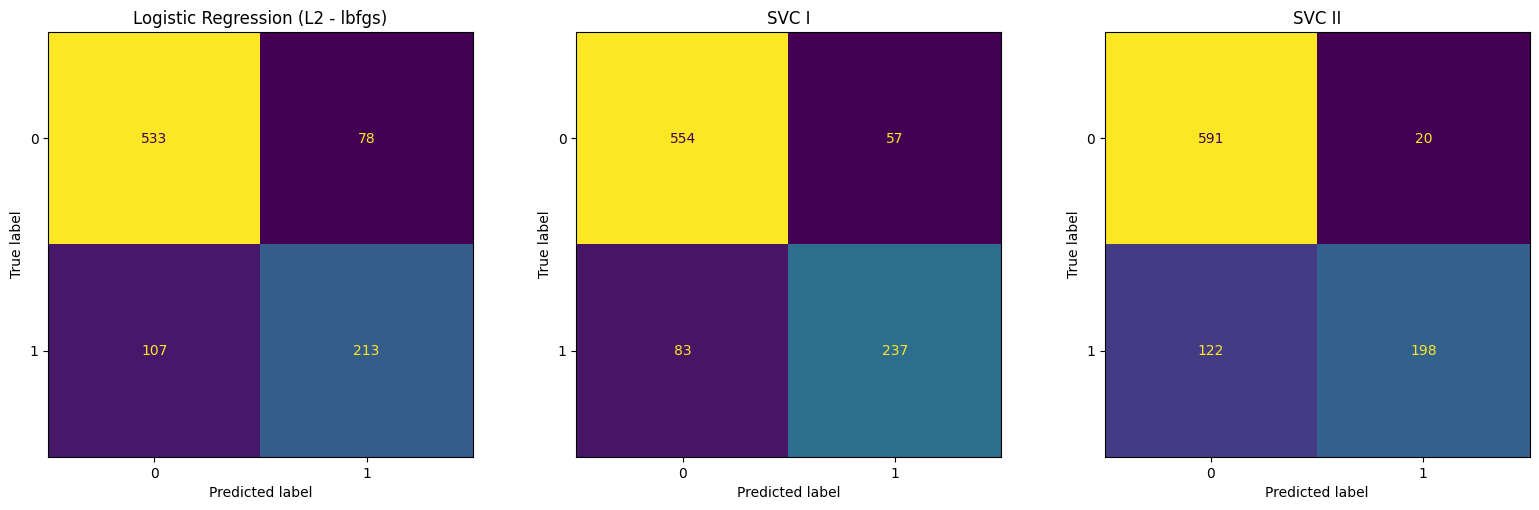

In [ ]:
# ===== Matrizes =====
cm_lr = confusion_matrix(y_test_false, y_pred_lr)
TN_lr, FP_lr, FN_lr, TP_lr = cm_lr.ravel()

cm_svc1 = confusion_matrix(y_test_false, y_pred_svc1)
TN_svc1, FP_svc1, FN_svc1, TP_svc1 = cm_svc1.ravel()

cm_svc2 = confusion_matrix(y_test_false, y_pred_svc2)
TN_svc2, FP_svc2, FN_svc2, TP_svc2 = cm_svc2.ravel()

# ===== Plot =====
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

ConfusionMatrixDisplay(cm_lr).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Logistic Regression (L2 - lbfgs)")

ConfusionMatrixDisplay(cm_svc1).plot(ax=axes[1], colorbar=False)
axes[1].set_title("SVC I")

ConfusionMatrixDisplay(cm_svc2).plot(ax=axes[2], colorbar=False)
axes[2].set_title("SVC II")

plt.tight_layout()
plt.show()


In [ ]:
# --- Métrica de negócio: Custo Esperado da Classificação --- 
C_ = 1000 # custo médio de uma saída não detectada 
C_investigacao = 50 # custo médio de investigar/bloquear uma saída legítima 

CEC_lr = (FN_lr * C_) + (FP_lr * C_investigacao) 
print("LR Custo Esperado da Classificação (CEC):", CEC_lr)

CEC_svc1 = (FN_svc1 * C_) + (FP_svc1 * C_investigacao) 
print("LGBM I Custo Esperado da Classificação (CEC):", CEC_svc1)

CEC_svc2 = (FN_svc2 * C_) + (FP_svc2 * C_investigacao) 
print("SVC Custo Esperado da Classificação (CEC):", CEC_svc2)

LR Custo Esperado da Classificação (CEC): 110900
LGBM I Custo Esperado da Classificação (CEC): 86650
SVC Custo Esperado da Classificação (CEC): 85850


## **Hiperparâmetros**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [5, 10, 12, 15],
    'gamma': ['scale', 'auto', 0.01, 0.001, 1],
    'kernel': ['rbf'],
    'probability': [True],
    'random_state': [42]
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1')

grid.fit(X_train_svc1, y_res)

print(grid.best_params_)


KeyboardInterrupt: 

In [ ]:
SVC(**grid.best_params_)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",5
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",1
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [ ]:
best_params = grid.best_params_ 

model_svc_opt = SVC(**best_params)

model_svc_opt.fit(X_train_svc1, y_res)

y_pred = model_svc_opt.predict(X_test_svc1)

print(classification_report(y_test_false, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       611
           1       0.73      0.69      0.71       320

    accuracy                           0.81       931
   macro avg       0.79      0.78      0.78       931
weighted avg       0.81      0.81      0.81       931



## **Tuned Threshold**

In [ ]:
tuned_model = TunedThresholdClassifierCV(
    estimator=SVC(**best_params),
    scoring='f1',
    store_cv_results=True,  # necessary to inspect all results
)
tuned_model.fit(X_train_svc1, y_res)

best_threshold = tuned_model.best_threshold_
print(f"Best threshold: {best_threshold:.3f}")

Best threshold: 0.507


In [ ]:
print(classification_report(y_test_false, tuned_model.predict(X_test_svc1)))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85       611
           1       0.71      0.73      0.72       320

    accuracy                           0.81       931
   macro avg       0.79      0.79      0.79       931
weighted avg       0.81      0.81      0.81       931



## **Rede Neural**

In [ ]:
import tensorflow as tf

print(tf.__version__)

2.20.0
